In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sympy import (symbols, simplify)
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
from sympy.physics.mechanics import Lagrangian, ReferenceFrame, Point, Particle,inertia, RigidBody

In [3]:
from optibot.symbolic import lagrange, diff_to_symb, SimpLagrangesMethod
from optibot.numpy import unpack

In [4]:
from functools import lru_cache

In [5]:
init_vprinting()

### Symbolic Problem Modelling

In [6]:
m0, m1, l, t, g = symbols('m_0 m_1 l t g')
q0, q1 = dynamicsymbols('q_0 q_1')

In [7]:
N_in = ReferenceFrame('N')
pN = Point('N*')
pN.set_vel(N_in, 0)

P0 = pN.locatenew('P0', q0 * N_in.x)
P0.set_vel(N_in, q0.diff(t) * N_in.x)
cart_part = Particle('CartPart', P0, m0)
cart_part.potential_energy = m0 * g * P0.pos_from(pN).dot(N_in.y)

N1 = N_in.orientnew('N1', 'Axis', [q1, N_in.z])
P1 = P0.locatenew('P1', -l*N1.y)
P1.set_vel(N_in, P1.pos_from(pN).dt(N_in))

pend_part = Particle('PendPart', P1, m1)
pend_part.potential_energy = m1 * g * P1.pos_from(pN).dot(N_in.y)

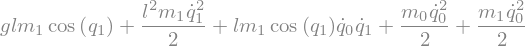

In [8]:
Lag_simp = Lagrangian(N_in, cart_part, pend_part)
Lag_simp

In [9]:
u0, u1 = symbols('u_0, u_1')
FL = [(P0, u0 * N_in.x)]#, (N1, u1 * N_in.z)]
LM_small = SimpLagrangesMethod(Lag_simp, [q0, q1], forcelist=FL, frame=N_in)

Generating M_inv
simplifying M_inv
simplifying RHS
Model completed


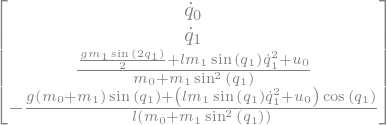

In [10]:
LM_small.form_lagranges_equations()
RHS_small = LM_small.rhs
RHS_small

In [11]:
num_pinv_dyn = LM_small.num_pinv_dyn([u0,])

### Casadi optimization

In [12]:
m0_n, m1_n = [1., 0.3]
l_n = 0.5
g_n = 9.81
params = [g_n, l_n, m0_n, m1_n]

In [13]:
import casadi as cas
from optibot.casadi import rhs_to_casadi_function, restriction2casadi
from optibot.schemes import euler_restr, trapz_restr, trapz_mod_restr, hs_mod_restr, hs_restr, hs_mod_restr, hs_parab_restr, hs_mod_parab_restr

In [14]:
F_cas_simp = rhs_to_casadi_function(RHS_small[2:], 2)

Function Arguments:
	x: [q_0, q_1, v_0, v_1]
	u: [u_0]
	params: [g, l, m_0, m_1]



In [15]:
def gen_ini_guess(N = 25, ini_guess = 'zero'):
    if ini_guess == 'zero':
        x_init_guess = np.zeros([N+1,4])
    elif ini_guess == 'lin':
        def_q1 = np.linspace(0,1,N+1)
        def_q2 = np.linspace(0,np.pi,N+1)
        def_v1 = np.zeros(N+1)
        def_v2 = np.zeros(N+1)
        x_init_guess = np.array([def_q1, def_q2, def_v1, def_v2]).T
    elif ini_guess == 'funcs':
        def_t = np.linspace(0,2,N+1)
        def_q1 = (0.8*np.arctan(def_t*3))**2
        def_q2 = -np.sin(3*def_t**0.8)*def_t*2
        def_v1 = np.sin(5*def_t)/(def_t+0.2)
        def_v2 = -3*np.sin(5*def_t**0.8)*(4*def_t - 2*def_t**2)
        x_init_guess = np.array([def_q1, def_q2, def_v1, def_v2]).T
    return x_init_guess

def sol_value(u_arr):
    N = len(u_arr)
    return(np.sum(u_arr[:]**2)+np.sum(u_arr[1:-1]**2))/N

In [16]:
def rand_array(shape, central, deviation):
    central = np.array(central)
    deviation = np.array(deviation)
    x = 2*(np.random.rand(*shape)-0.5)
    x = deviation * x
    x = central + x
    return x

In [17]:
import time
def chrono_solve(opti, solve_repetitions):
    cput0 = time.time()
    for ii in range(solve_repetitions):
        sol = opti.solve()
    cput1 = time.time()
    cpudt = (cput1-cput0)/solve_repetitions
    return sol, cpudt


def chrono_solve_random_init(opti, solve_repetitions, u_opti, u_lim, x_opti, x_0, x_f, cost):
    cpudt = 0.
    err_count = 0
    mean_cost = 0.
    if not (type(u_lim) == int or type(u_lim) == float):
        u_lim = opti.value(u_lim)
    if type(x_0) == cas.MX:
        x_0 = opti.value(x_0)
    if type(x_f) == cas.MX:
        x_f = opti.value(x_f)
    x_0 = np.array(x_0)
    x_f = np.array(x_f)
        
        
    for ii in range(solve_repetitions):
        unresolved = True
        while unresolved:
            try:
                rnd_u = rand_array(u_opti.shape, 0, u_lim)
                x_dev = 2*(x_f-x_0)
                dim = x_dev.shape[0]//2
                x_dev[dim:] += 10 * x_dev[:dim]
                rnd_x = rand_array(x_opti.shape, (x_0+x_f)/2, x_dev)
                opti.set_initial(u_opti, rnd_u)
                opti.set_initial(x_opti, rnd_x)
                cput0 = time.time()
                sol = opti.solve()
                cput1 = time.time()
            except RuntimeError:
                print('*', end='')
                err_count += 1
            else:
                unresolved = False
                print('.', end='')
        cpudt += (cput1-cput0)
        mean_cost += sol.value(cost)
    cpudt = cpudt/solve_repetitions
    mean_cost = mean_cost/solve_repetitions
    return sol, cpudt, err_count/solve_repetitions, mean_cost

In [42]:
#@lru_cache
def casadi_cartpole(N = 25, scheme = 'euler', ini_guess = 'zero', solve_repetitions = 1, t_end = 2):
    opti = cas.Opti()
    p_opts = {"expand":True,'ipopt.print_level':0, 'print_time':0}
    s_opts = {"max_iter": 10000, 'tol': 1e-26}#, 'linear_solver' : "MA27"}
    opti.solver("ipopt",p_opts,
                        s_opts)
    restr_schemes = {
        'euler': euler_restr,
        'trapz': trapz_restr,
        'trapz_mod' : trapz_mod_restr,
        'hs': hs_restr,
        'hs_mod': hs_mod_restr,
        'hs_parab': hs_parab_restr,
        'hs_mod_parab': hs_mod_parab_restr
    }
    
    f_restr = restr_schemes[scheme]
    if scheme in ['hs_parab', 'hs_mod_parab']:
        parab = True
    else:
        parab = False
    X = opti.variable(N+1,4)
    U = opti.variable(N+1)
    if parab:
        U_c = opti.variable(N)
    T = opti.parameter()
    u_m = opti.parameter()
    Params = opti.parameter(4)

    cost = (cas.sum1(U[:]**2)+cas.sum1(U[1:-1]**2))/N
    if parab:
        cost = (4*cas.sum1(U_c[:]**2) + cas.sum1(U[:]**2)+cas.sum1(U[1:-1]**2))/(3*N)
    #cost = cas.sum1(cas.cos(X[:,1]))
    #cost = T
    opti.minimize(cost)

    opti.subject_to(X[0,:].T == [0, 0, 0, 0])
    opti.subject_to(X[-1,:].T == [1, np.pi, 0, 0])
    if parab: 
        restriction = restriction2casadi(f_restr, F_cas_simp, 2, 1, 4, 1)
    else:
        restriction = restriction2casadi(f_restr, F_cas_simp, 2, 1, 4)

    for ii in range(N):
        if parab:
            opti.subject_to(restriction(X[ii,:], X[ii+1,:], U[ii,:], U[ii+1],T/N, Params, U_c[ii])==0)
            opti.subject_to(opti.bounded(-u_m, U_c[ii,:] ,u_m))
        else:
            opti.subject_to(restriction(X[ii,:], X[ii+1,:], U[ii,:], U[ii+1,:],T/N, Params)==0)
        opti.subject_to(opti.bounded(-u_m,U[ii,:],u_m))

    opti.subject_to(opti.bounded(-u_m,U[-1, :],u_m))
    opti.set_value(T, t_end)
    max_f = 20.0
    opti.set_value(u_m, max_f)

    m0_n, m1_n = [1., 0.3]
    l_n = 0.5
    g_n = 9.81
    opti.set_value(Params, [g_n, l_n, m0_n, m1_n])
    
    if ini_guess in ['zero', 'lin', 'funcs']:
        opti.set_initial(X, gen_ini_guess(N, ini_guess))
    elif type(ini_guess) == list:
        opti.set_initial(X, ini_guess[0])
        opti.set_initial(U, ini_guess[1])
        if parab:
            opti.set_initial(U_c, ini_guess[2])
    elif ini_guess == 'random':
        pass
    else:
        raise TypeError('initial guess not understood')
    if ini_guess == 'lin':
        #Ensuring solution corresponds to kellys minimum
        #opti.subject_to(X[:2,0]>= 0)
        pass
    if ini_guess == 'random':
        sol, cpudt, err_count, sol_cost = chrono_solve_random_init(
            opti,
            solve_repetitions,
            U,
            u_m,
            X,
            0,
            [1, np.pi, 0, 0],
            cost)
    else:
        sol, cpudt = chrono_solve(opti, solve_repetitions)
        err_count = None
        sol_cost = sol.value(cost)
    xx_simp = sol.value(X)
    uu_simp = sol.value(U)
    if parab:
        uu_c = sol.value(U_c)
    else:
        uu_c = None
    return xx_simp, uu_simp, uu_c, cpudt, err_count, sol_cost

In [133]:
schemes = ['hs_parab', 'hs_mod_parab', 'trapz', 'trapz_mod']#'hs', 'hs_mod', 
initials = ['lin']#, 'funcs']
solve_repetitions = 1#00
N_arr = [20, 25, 30, 40, 50, 60, 80, 100, 120, 160, 200]
results = {}

for scheme in schemes:
    for init in initials:
        key = scheme + '_' + init
        print('Problem:', key)
        results[key] = {'N_arr':N_arr}
        for N in N_arr:
            print(f'\tN = {N}')
            xx, uu, uu_c, cpudt, _, cost = casadi_cartpole(N, scheme, init, solve_repetitions)
            results[key][N] = {
                'x': xx,
                'u': uu,
                'u_c': uu_c,
                'cpudt': cpudt,
                'cost': cost
            }


#xx_hs_lin, uu_hs_lin, _, cpudt_hs_lin = casadi_cartpole(25, 'hs', ini_guess = 'lin', solve_repetitions = 10)
#xx_hs_fun, uu_hs_fun, _, cpudt_hs_fun = casadi_cartpole(25, 'hs', ini_guess = 'funcs', solve_repetitions = 10)
#xx_mod_lin, uu_mod_lin, _, cpudt_mod_lin = casadi_cartpole(25, 'hs_mod', ini_guess = 'lin', solve_repetitions = 10)
#xx_mod_fun, uu_mod_fun, _, cpudt_mod_fun = casadi_cartpole(25, 'hs_mod', ini_guess = 'funcs', solve_repetitions = 10)

#xx_hs_par_lin, uu_hs_par_lin, uu_c_hs_par_lin, cpudt_hs_par_lin = casadi_cartpole(25, 'hs_parab', ini_guess = 'lin', solve_repetitions = 10)
#xx_hs_par_fun, uu_hs_par_fun, uu_c_hs_par_fun, cpudt_hs_par_fun = casadi_cartpole(25, 'hs_parab', ini_guess = 'funcs', solve_repetitions = 10)
#xx_mod_par_lin, uu_mod_par_lin, uu_c_mod_par_lin, cpudt_mod_par_lin = casadi_cartpole(25, 'hs_mod_parab', ini_guess = 'lin', solve_repetitions = 10)
#xx_mod_par_fun, uu_mod_par_fun, uu_c_mod_par_fun, cpudt_mod_par_fun = casadi_cartpole(25, 'hs_mod_parab', ini_guess = 'funcs', solve_repetitions = 10)

Problem: hs_parab_lin
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200
Problem: hs_mod_parab_lin
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200
Problem: trapz_lin
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200
Problem: trapz_mod_lin
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200


In [124]:
for scheme in ['hs_mod_parab', 'hs_parab', 'trapz', 'trapz_mod']:
    key = scheme + '_lin'
    for N in results[key]['N_arr']:
        print('cost:', results[key][N]['cost'], 'scheme:', scheme, 'N:', N)


cost: 58.65842043795789 scheme: hs_mod_parab N: 20
cost: 58.79539609032136 scheme: hs_mod_parab N: 25
cost: 58.805476463772095 scheme: hs_mod_parab N: 30
cost: 58.80612864477701 scheme: hs_mod_parab N: 40
cost: 58.807053249063635 scheme: hs_mod_parab N: 50
cost: 58.80737252442072 scheme: hs_mod_parab N: 60
cost: 58.80757446342755 scheme: hs_mod_parab N: 80
cost: 58.80762942816674 scheme: hs_mod_parab N: 100
cost: 58.80764913371678 scheme: hs_mod_parab N: 120
cost: 58.80766166506036 scheme: hs_mod_parab N: 160
cost: 58.80766508622485 scheme: hs_mod_parab N: 200
cost: 58.702668779027 scheme: hs_parab N: 20
cost: 58.80542546846037 scheme: hs_parab N: 25
cost: 58.80960350000824 scheme: hs_parab N: 30
cost: 58.807575897486416 scheme: hs_parab N: 40
cost: 58.807642165912995 scheme: hs_parab N: 50
cost: 58.807656072930364 scheme: hs_parab N: 60
cost: 58.8076640408182 scheme: hs_parab N: 80
cost: 58.807666091949734 scheme: hs_parab N: 100
cost: 58.80766680775334 scheme: hs_parab N: 120
cost: 5

In [76]:
def parab_cost(U, U_c, N = 25):
    cost = (4*cas.sum1(U_c[:]**2) + cas.sum1(U[:]**2)+cas.sum1(U[1:-1]**2))/(3*N)
    return cost

In [77]:
for scheme in schemes:
    for init in initials:
        key = scheme + '_' + init
        print(key, results[key][25]['cpudt'])

hs_parab_lin 0.04871225357055664
hs_mod_parab_lin 0.05661296844482422
trapz_lin 0.027862071990966797
trapz_mod_lin 0.028338909149169922


plt.figure(figsize=[16,10])
labels = ['q1','q2','v1','v2']
#for ii in range(4):
ii = 0
key = 'hs_parab_lin'
plt.plot(results[key][25]['x'][:,ii], label = labels[ii])
key = 'hs_mod_parab_lin'
plt.plot(results[key][25]['x'][:,ii], label = labels[ii])
plt.grid()
plt.legend()

plt.figure(figsize=[16,10])
key = 'hs_parab_lin'
plt.plot(np.linspace(0,2,26),results[key][25]['u'][:], 'o',label = 'u Siro')
plt.plot(np.linspace(0,2,51)[1::2],results[key][25]['u_c'][:], 'o',label = 'u_c Siro')
plt.grid()
plt.legend()


In [78]:
from optibot.schemes import integrate_hs, integrate_trapz, integrate_euler, integrate_rk4, integrate_hs_mod

In [79]:
from optibot.numpy import RHS2numpy

In [80]:
F_nump = RHS2numpy(RHS_small, 2)

Function Arguments:
	x: [q_0, q_1, v_0, v_1]
	u: [u_0]
	params: [g, l, m_0, m_1]



In [81]:
F_nump([0,0,0,0],[0.5,], params)

array([ 0. ,  0. ,  0.5, -1. ])

In [82]:
from optibot.schemes import interpolated_array, interpolated_array_derivative
from optibot.analysis import dynamic_error

In [83]:
for scheme in results.keys():
    if 'hs' in scheme:
        n_coll = np.array(results[scheme]['N_arr'])*2-1
        results[scheme]['N_coll_arr'] = n_coll
    else:
        results[scheme]['N_coll_arr'] = results[scheme]['N_arr']
    print(scheme, results[scheme]['N_arr'],results[scheme]['N_coll_arr'])

hs_parab_lin [20, 25, 30, 40, 50, 60, 80, 100, 120, 160, 200] [ 39  49  59  79  99 119 159 199 239 319 399]
hs_mod_parab_lin [20, 25, 30, 40, 50, 60, 80, 100, 120, 160, 200] [ 39  49  59  79  99 119 159 199 239 319 399]
trapz_lin [20, 25, 30, 40, 50, 60, 80, 100, 120, 160, 200] [20, 25, 30, 40, 50, 60, 80, 100, 120, 160, 200]
trapz_mod_lin [20, 25, 30, 40, 50, 60, 80, 100, 120, 160, 200] [20, 25, 30, 40, 50, 60, 80, 100, 120, 160, 200]


key = 'hs_parab_funcs'
N_prob = 25
xx_hs_parab_lin_int, uu_hs_parab_lin_int = interpolated_array(
    X = results[key][N_prob]['x'],
    U = results[key][N_prob]['u'],
    F = F_nump,
    h = 2/N_prob,
    t_array = np.linspace(0, 2, 2000),
    params = params,
    scheme = "hs_parab",
    u_scheme = 'parab',
    scheme_params = {'u_c' : results[key][N_prob]['u_c']}
)
plt.figure(figsize=[16,8])
plt.plot(np.linspace(0,2,N_prob+1),results[key][N_prob]['u'][:], 'o',label = 'u Siro')
plt.plot(np.linspace(0,2,2*N_prob+1)[1::2],results[key][N_prob]['u_c'][:], 'o',label = 'u_c Siro')
plt.plot(np.linspace(0,2,2000),uu_hs_parab_lin_int, label = 'interp Siro')
plt.grid()
plt.legend()
ii = 3
plt.figure(figsize=[16,10])
plt.plot(np.linspace(0,2,N_prob+1),results[key][N_prob]['x'][:,ii], 'o',label = 'X Siro')
plt.plot(np.linspace(0,2,2000),xx_hs_parab_lin_int[:,ii], label = 'interp Siro')
plt.grid()
plt.legend()

In [84]:
n_graph = 4000
t_arr = np.linspace(0,2,n_graph)
key = 'hs_parab_lin'
dyn_err_q_hs_lin, dyn_err_v_hs_lin, dyn_err_2_a_hs_lin, dyn_err_2_b_hs_lin = dynamic_error(
    x_arr=results[key][25]['x'],
    u_arr=results[key][25]['u'],
    t_end=2,
    params = params,
    F = F_nump,
    scheme = 'hs_parab', 
    u_scheme='parab',
    scheme_params={'u_c':results[key][25]['u_c']},
    n_interp= n_graph)

for ii in range(2):
    plt.figure(figsize=[14,8])
    plt.plot(t_arr,-dyn_err_q_hs_lin[:,ii], '-', label = f'q {ii}')
    plt.plot(np.linspace(0,2,26), np.zeros(26), 'ok')
    plt.legend()
    plt.grid()

n_graph = 10000
t_arr = np.linspace(0,2,n_graph)
key = 'hs_parab_lin'
dyn_err_q_hs_lin, dyn_err_v_hs_lin, dyn_err_2_a_hs_lin, dyn_err_2_b_hs_lin = dynamic_error(
    results[key][25]['x'], results[key][25]['u'], 2, params, F_nump,
    scheme = 'hs_parab', u_scheme='parab', scheme_params={'u_c':results[key][25]['u_c']},
    n_interp= n_graph)


plt.figure(figsize=[14,8])
ii = 0
plt.plot(t_arr,dyn_err_v_hs_lin[:,ii], '-', label = f'q {ii}')
plt.plot(np.linspace(0,2,26), np.zeros(26), 'ok')
plt.legend()
plt.grid()
plt.figure(figsize=[14,8])
ii = 1
plt.plot(t_arr,dyn_err_v_hs_lin[:,ii], '-', label = f'q {ii}')
plt.plot(np.linspace(0,2,26), np.zeros(26), 'ok')
plt.legend()
plt.grid()

n_graph = 10000
t_arr = np.linspace(0,2,n_graph)
key = 'hs_lin'
dyn_err_q_hs_lin, dyn_err_v_hs_lin, dyn_err_2_a_hs_lin, dyn_err_2_b_hs_lin = dynamic_error(
    results[key][25]['x'], results[key][25]['u'], 2, params, F_nump,
    scheme = 'hs', scheme_params={'u_c':results[key][25]['u_c']},
    n_interp= n_graph)


plt.figure(figsize=[14,8])
ii = 0
plt.plot(t_arr,dyn_err_v_hs_lin[:,ii], '-', label = f'q {ii}')
plt.plot(np.linspace(0,2,26), np.zeros(26), 'ok')
plt.legend()
plt.grid()
plt.figure(figsize=[14,8])
ii = 1
plt.plot(t_arr,dyn_err_v_hs_lin[:,ii], '-', label = f'q {ii}')
plt.plot(np.linspace(0,2,26), np.zeros(26), 'ok')
plt.legend()
plt.grid()

In [85]:
def state_error(t_arr, dyn_err, N,):
    n_int = len(t_arr)
    interv_n = (N * t_arr)//2
    err = []
    cut_p = 0
    for ii in range(1,N+1):
        jj = np.searchsorted(interv_n, ii)
        err_point = np.trapz(np.abs(dyn_err[cut_p:jj+1]), t_arr[cut_p:jj+1], axis=0)
        err.append(err_point)
        cut_p = jj
    err = np.array(err, dtype = float)
    return err

def total_state_error(t_arr, dyn_err):
    errors = np.trapz(np.abs(dyn_err), t_arr, axis=0)
    return errors

st_err = state_error(t_arr, dyn_err_2_b_hs_lin, 25)
plt.figure(figsize=[12,6])
ii = 0
plt.plot(np.linspace(0,2,26)[1:],st_err[:,ii], 'o', label = f'q {ii}')
plt.legend()
plt.grid()
plt.figure(figsize=[12,6])
ii = 1
plt.plot(np.linspace(0,2,26)[1:],st_err[:,ii], 'o', label = f'q {ii}')
plt.legend()
plt.grid()

In [137]:
schemes = ['hs_parab', 'hs_mod_parab', 'trapz', 'trapz_mod']#'hs','hs_mod', 
initials = ['lin']#, 'funcs']
n_interp = 4000
for scheme in schemes:
    for init in initials:
        key = scheme + '_' + init
        print('Problem:', key)
        N_arr = results[key]['N_arr']
        for N in N_arr:
            print(f'\tN = {N}')
            if 'parab' in scheme:
                u_scheme = 'parab'
            else:
                u_scheme = 'lin'
            dyn_err_q, dyn_err_v, dyn_err_2_a, dyn_err_2_b = dynamic_error(
                results[key][N]['x'],
                results[key][N]['u'],
                2,
                params,
                F_nump,
                scheme = scheme,
                u_scheme= u_scheme,
                scheme_params={'u_c':results[key][N]['u_c']},
                n_interp = n_interp)
            t_arr = np.linspace(0,2, n_interp)
            tot_dyn_err_q = total_state_error(t_arr, dyn_err_q)
            tot_dyn_err_v = total_state_error(t_arr, dyn_err_v)
            tot_dyn_err_2_a = total_state_error(t_arr, dyn_err_2_a)
            tot_dyn_err_2_b = total_state_error(t_arr, dyn_err_2_b)
            results[key][N]['err_q_int'] = dyn_err_q
            results[key][N]['err_v_int'] = dyn_err_v
            results[key][N]['err_2_a_int'] = dyn_err_2_a
            results[key][N]['err_2_b_int'] = dyn_err_2_b
            results[key][N]['err_q'] = tot_dyn_err_q
            results[key][N]['err_v'] = tot_dyn_err_v
            results[key][N]['err_2_a'] = tot_dyn_err_2_a
            results[key][N]['err_2_b'] = tot_dyn_err_2_b

Problem: hs_parab_lin
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200
Problem: hs_mod_parab_lin
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200
Problem: trapz_lin
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200
Problem: trapz_mod_lin
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 60
	N = 80
	N = 100
	N = 120
	N = 160
	N = 200


In [138]:
#schemes = ['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
#initials = ['lin', 'funcs']
for scheme in schemes:
    for init in initials:
        key = scheme + '_' + init
        print('Problem:', key)
        N_arr = results[key]['N_arr']
        err_q_acum = []
        err_v_acum = []
        err_2_a_acum = []
        err_2_b_acum = []
        cpudt = []
        for N in N_arr:
            err_q_acum.append(results[key][N]['err_q'])
            err_v_acum.append(results[key][N]['err_v'])
            err_2_a_acum.append(results[key][N]['err_2_a'])
            err_2_b_acum.append(results[key][N]['err_2_b'])
            cpudt.append(results[key][N]['cpudt'])
        results[key]['err_q_acum'] = np.array(err_q_acum, dtype = float)
        results[key]['err_v_acum'] = np.array(err_v_acum, dtype = float)
        results[key]['err_2_a_acum'] = np.array(err_2_a_acum, dtype = float)
        results[key]['err_2_b_acum'] = np.array(err_2_b_acum, dtype = float)
        results[key]['cpudt'] = np.array(cpudt, dtype = float)

Problem: hs_parab_lin
Problem: hs_mod_parab_lin
Problem: trapz_lin
Problem: trapz_mod_lin


In [139]:
plt.rcParams.update({'font.size': 15})
oct_fig_size = [10,6]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


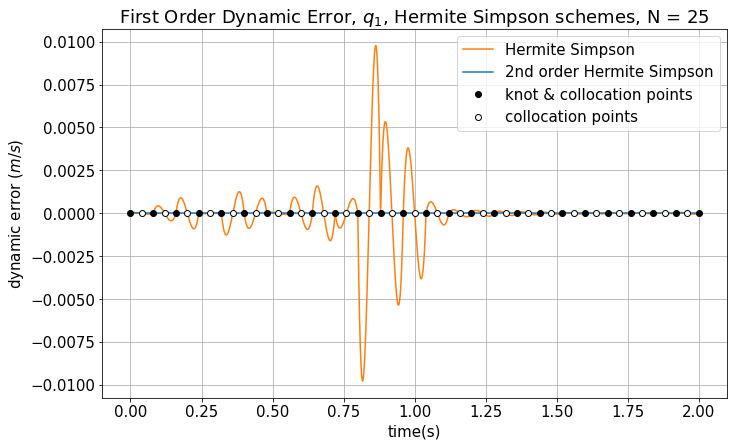

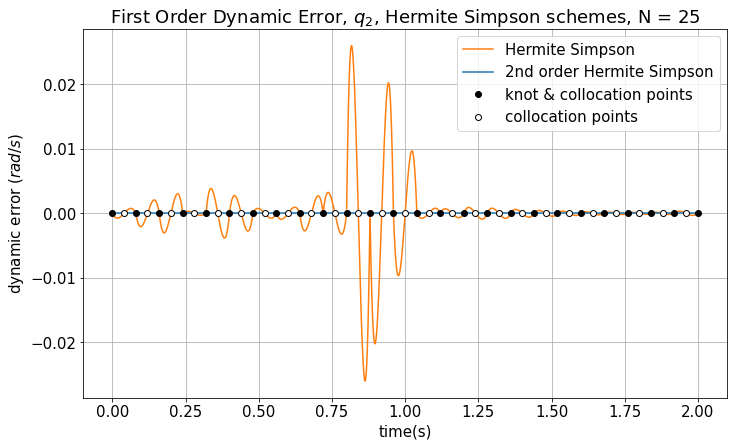

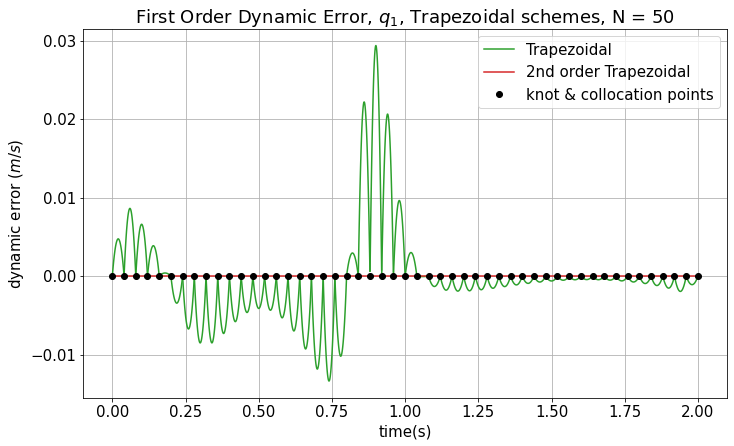

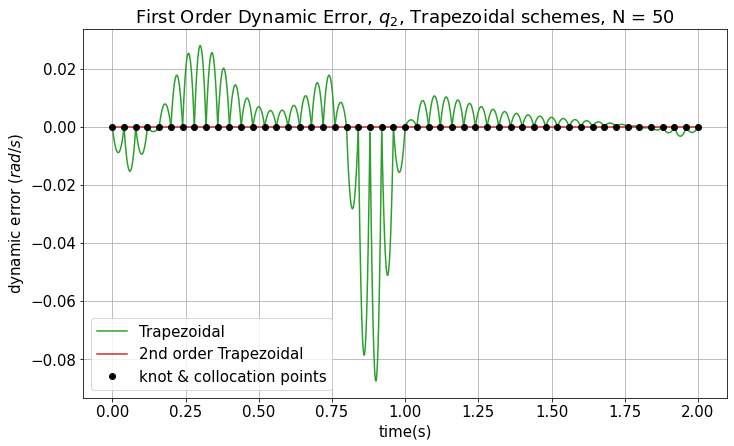

In [151]:
sch = [['hs_parab','hs_mod_parab'],['trapz', 'trapz_mod']]
tit = [['Hermite Simpson','2nd order Hermite Simpson'],['Trapezoidal', '2nd order Trapezoidal']]
colors = [f'C{ii}' for ii in [1,0,2,3]]
n_int = len(t_arr)
N_hh = [25,50]
for hh in range(2):
    schemes = sch[hh]
    titles = tit[hh]
    N = N_hh[hh]
    interv_n = (N * t_arr)/2
    for ii in range(2):
        plt.figure(figsize=oct_fig_size)
        for kk in range(len(schemes)):
            scheme = schemes[kk]
            key = scheme + '_lin'
            cut_p = 0
            for ll in range(1,N+1):
                jj = np.searchsorted(interv_n, ll)
                plt.plot(t_arr[cut_p:jj],results[key][N]['err_q_int'][cut_p:jj,ii], '-', c = colors[2*hh+kk], label = titles[kk] if cut_p == 0 else None)
                cut_p = jj
        plt.plot(np.linspace(0,2,N+1), np.zeros(N+1), 'ok', label = 'knot & collocation points')
        if hh == 0:
            plt.plot(np.linspace(0,2,2*N+1)[1::2], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
        plt.legend()
        plt.grid()
        #plt.ylim([-0.00022, 0.00022])
        plt.title(f'First Order Dynamic Error, $q_{ii+1}$, {titles[0]} schemes, N = {N}')
        plt.xlabel('time(s)')
        units = 'm/s' if ii == 0 else'rad/s'
        plt.ylabel(f'dynamic error $({units})$')
        plt.tight_layout(pad = 0.0)
        sch_type = titles[0].replace(' ','_')
        plt.savefig(f'Cartpole_First_Order_Dynamic_Error_q_{ii+1}_{sch_type}_schemes_N_{N}.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


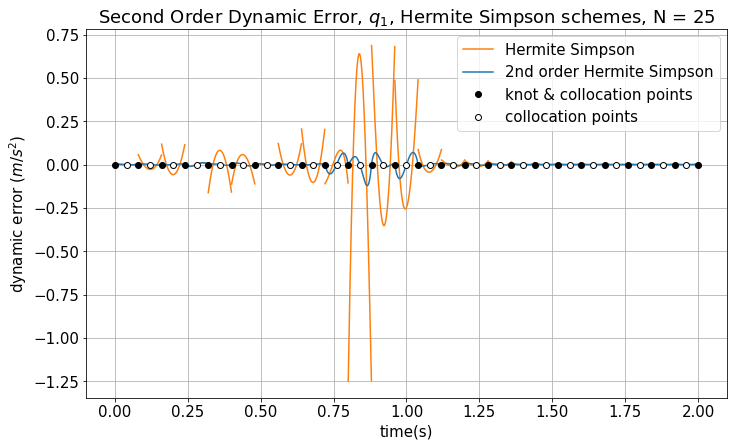

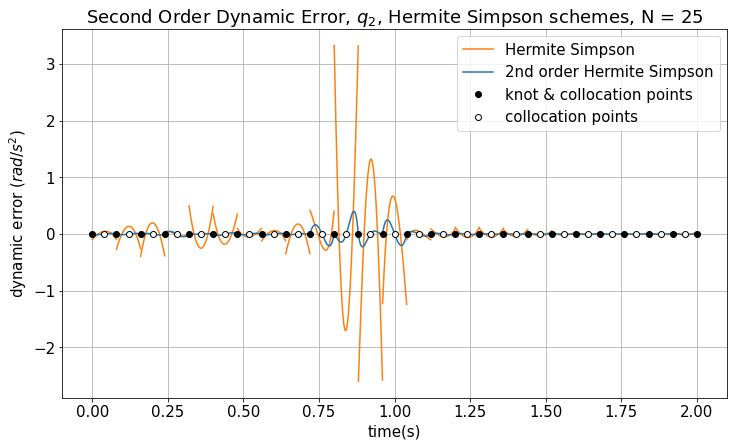

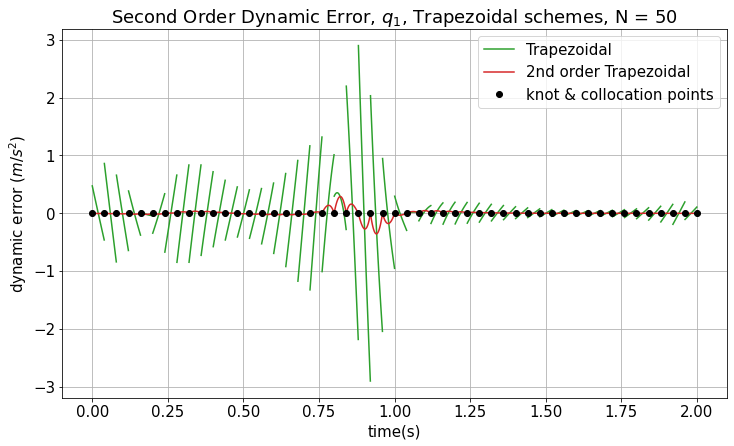

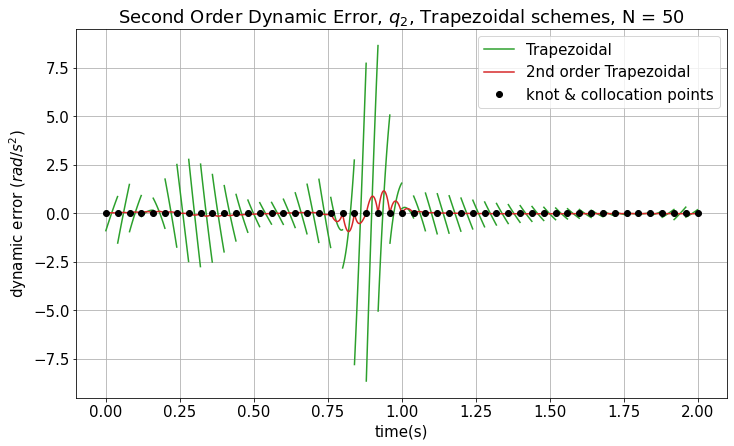

In [152]:
sch = [['hs_parab','hs_mod_parab'],['trapz', 'trapz_mod']]
tit = [['Hermite Simpson','2nd order Hermite Simpson'],['Trapezoidal', '2nd order Trapezoidal']]
colors = [f'C{ii}' for ii in [1,0,2,3]]
n_int = len(t_arr)
N_hh = [25,50]
for hh in range(2):
    schemes = sch[hh]
    titles = tit[hh]
    N = N_hh[hh]
    interv_n = (N * t_arr)/2
    for ii in range(2):
        plt.figure(figsize=oct_fig_size)
        for kk in range(len(schemes)):
            scheme = schemes[kk]
            key = scheme + '_lin'
            cut_p = 0
            for ll in range(1,N+1):
                jj = np.searchsorted(interv_n, ll)
                plt.plot(t_arr[cut_p:jj],results[key][N]['err_2_b_int'][cut_p:jj,ii], '-', c = colors[2*hh+kk], label = titles[kk] if cut_p == 0 else None)
                cut_p = jj
        plt.plot(np.linspace(0,2,N+1), np.zeros(N+1), 'ok', label = 'knot & collocation points')
        if hh == 0:
            plt.plot(np.linspace(0,2,2*N+1)[1::2], np.zeros(N), 'ow', markeredgecolor='k', label = 'collocation points')
        plt.legend()
        plt.grid()
        #plt.ylim([-0.00022, 0.00022])
        plt.title(f'Second Order Dynamic Error, $q_{ii+1}$, {titles[0]} schemes, N = {N}')
        plt.xlabel('time(s)')
        units = 'm/s^2' if ii == 0 else'rad/s^2'
        plt.ylabel(f'dynamic error $({units})$')
        plt.tight_layout(pad = 0.0)
        sch_type = titles[0].replace(' ','_')
        plt.savefig(f'Cartpole_Second_Order_Dynamic_Error_q_{ii+1}_{sch_type}_schemes_N_{N}.eps', format='eps')

Problem: trapz_lin
Problem: trapz_mod_lin
Problem: hs_parab_lin
Problem: hs_mod_parab_lin


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Problem: trapz_lin
Problem: trapz_mod_lin
Problem: hs_parab_lin
Problem: hs_mod_parab_lin


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


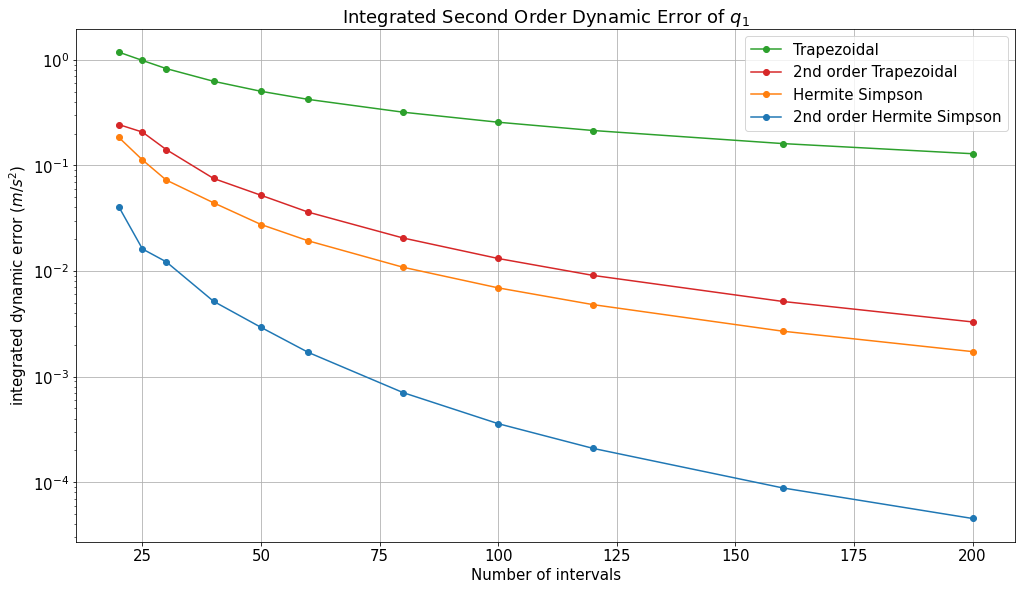

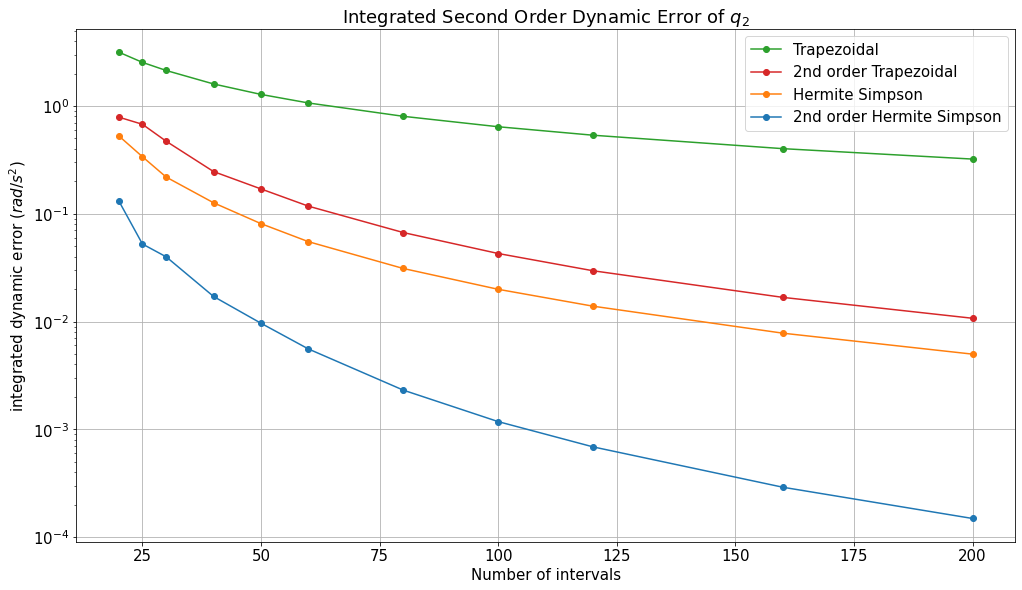

In [147]:
schemes_graph = ['hs_mod_parab', 'hs_parab', 'trapz', 'trapz_mod']
titles = ['2nd order Hermite Simpson', 'Hermite Simpson','Trapezoidal', '2nd order Trapezoidal']
colors = [f'C{ii}' for ii in range(9)]
data_array = ['err_q_acum','err_v_acum','err_2_b_acum','cpudt']
initial = 'lin'


data_key = data_array[2]
for qq in range(2):
    plt.figure(figsize=[14,8])
    plt.title(f'Integrated Second Order Dynamic Error of $q_{qq+1}$')
    for ii in [2,3,1,0]:
        scheme = schemes_graph[ii]
        key = scheme + '_' + initial
        print('Problem:', key)
        N_arr = results[key]['N_arr']
        if len(results[key][data_key].shape) == 1:
            plt.plot(N_arr,results[key][data_key], marker = 'o', c = f'C{ii}',label = titles[ii])
        else:
            plt.plot(N_arr,results[key][data_key][:,qq], marker = 'o', c = f'C{ii}',label = titles[ii])
    plt.yscale('log')
    plt.xlabel('Number of intervals')
    plt.grid()
    plt.legend()
    units = 'm/s^2' if qq == 0 else'rad/s^2'
    plt.ylabel(f'integrated dynamic error $({units})$')
    plt.tight_layout(pad = 0.0)
    plt.savefig(f'Cartpole_Integrated_Second_Order_Dynamic_Error_q_{qq+1}_vs_N.eps', format='eps')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


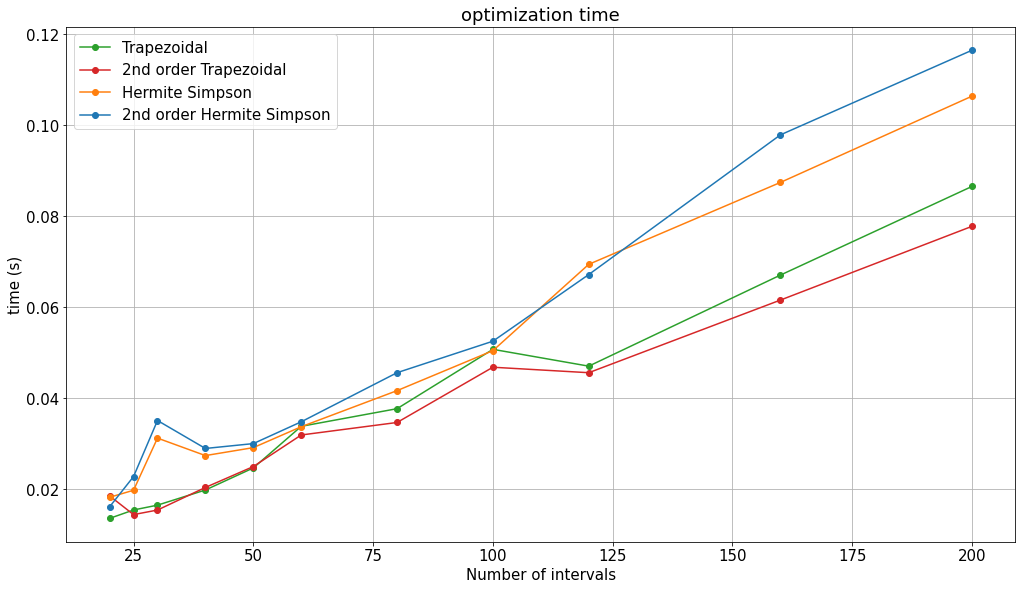

In [148]:
schemes = ['hs_mod_parab','hs_parab', 'trapz', 'trapz_mod']
titles = ['2nd order Hermite Simpson', 'Hermite Simpson','Trapezoidal', '2nd order Trapezoidal']
plt.figure(figsize=[14,8])
for ii in [2,3,1,0]:
    key = schemes[ii] + '_lin'
    plt.plot(results[key]['N_arr'], results[key][f'cpudt'], marker = 'o', c = f'C{ii}',label = titles[ii])
plt.grid()
plt.legend()
#plt.yscale('log')
plt.title('optimization time')
plt.xlabel('Number of intervals')
plt.ylabel('time (s)')
plt.tight_layout(pad = 0.0)
plt.savefig(f'Cartpole_optimization_time_vs_interval_number.eps', format='eps')

In [145]:

for scheme in ['hs_mod_parab', 'hs_parab', 'trapz', 'trapz_mod']:
    key = scheme + '_lin'
    for N in [25,50]:#results[key]['N_arr']:
        print('scheme:', scheme, 'N:', N,'\n\ttime:', results[key][N][f'cpudt'],
              '\n\tErr 1:', results[key][N]['err_q'], '\n\tErr 2:', results[key][N]['err_2_b'])

scheme: hs_mod_parab N: 25 
	time: 0.022797391414642335 
	Err 1: [4.12099851e-21 4.90181927e-20] 
	Err 2: [0.01619108 0.05244047]
scheme: hs_mod_parab N: 50 
	time: 0.030052101612091063 
	Err 1: [1.64297704e-20 1.03079186e-19] 
	Err 2: [0.00292946 0.00964465]
scheme: hs_parab N: 25 
	time: 0.019794862270355224 
	Err 1: [0.00142504 0.00426054] 
	Err 2: [0.11286157 0.33838219]
scheme: hs_parab N: 50 
	time: 0.02916323184967041 
	Err 1: [0.00017659 0.00051872] 
	Err 2: [0.02759557 0.08098026]
scheme: trapz N: 25 
	time: 0.015459060668945312 
	Err 1: [0.0255378  0.06323753] 
	Err 2: [0.98742787 2.54096757]
scheme: trapz N: 50 
	time: 0.024700939655303955 
	Err 1: [0.00661607 0.01670533] 
	Err 2: [0.50375109 1.2809468 ]
scheme: trapz_mod N: 25 
	time: 0.014442660808563233 
	Err 1: [6.68035547e-19 2.92200483e-18] 
	Err 2: [0.20703075 0.67662222]
scheme: trapz_mod N: 50 
	time: 0.02500399112701416 
	Err 1: [1.11483854e-19 2.38584124e-19] 
	Err 2: [0.05221009 0.17002857]


array([1.11483854e-19, 2.38584124e-19])

### Other checks

In [61]:
from optibot.schemes import hs_opti_step, hs_mod_opti_step, hs_parab_opti_step, hs_mod_parab_opti_step

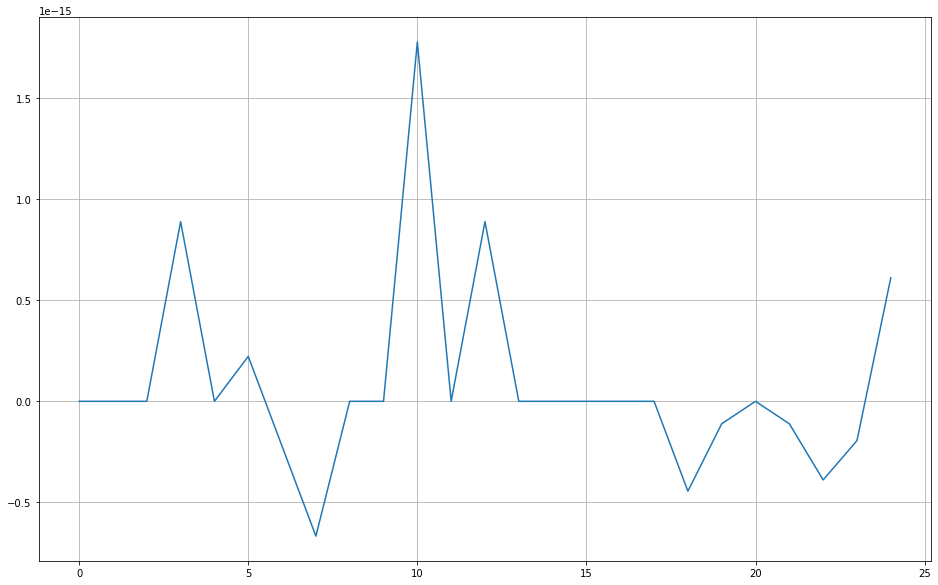

In [62]:
eq_err_Siro_notop = []
kk  = 3
for ii in range(25):
    eq_err_Siro_notop.append(
        list(hs_parab_opti_step(#función de optimización implícita, debe ser = 0
            results['hs_parab_lin'][25]['x'][ii+1,:],
            results['hs_parab_lin'][25]['x'][ii,:],
            results['hs_parab_lin'][25]['u'][ii],
            results['hs_parab_lin'][25]['u'][ii+1],
            F_nump, 2/25, params,
            results['hs_parab_lin'][25]['u_c'][ii]))
    )
eq_err_Siro_notop = np.array(eq_err_Siro_notop)
plt.figure(figsize=[16,10])
plt.plot(eq_err_Siro_notop[:,kk], label = 'eq_err_Siro_notop')
plt.grid()

In [63]:
def x_central(x, x_n, h, f, f_n):
        return (x + x_n)/2 + h/8*(f-f_n)
    

## Integration Error and different T_end

In [64]:
from optibot.schemes import integrate_rk4, interpolate_u
def integrate_cartpole_from_u(
        X_0, U, F, h, params, int_fun = integrate_rk4, u_scheme="lin", scheme_params={}, n_interp = 3000
    ):
    t_end = (U.shape[0] - 1) * h
    t_array = np.linspace(0, t_end, n_interp)
    old_t_array = np.linspace(0, t_end, U.shape[0])
    uu = interpolate_u(U, old_t_array, t_array, u_scheme, scheme_params)
    dt = t_end / (n_interp-1)
    xx = int_fun(X_0, uu, F, dt, params)[:-1]
    return xx,uu

In [65]:
from optibot.schemes import _newpoint
def integrate_cartpole_segmented(
        X, U, F, h, params, 
        int_fun = integrate_rk4,
        scheme = 'hs_scipy',
        u_scheme="lin",
        scheme_params=[],
        n_interp = 3000
    ):
    segments = U.shape[0] - 1 #num de segmentos
    t_end = segments * h 
    n_seg = n_interp // segments + 1 #num de intervalos en cada segmento
    n_interp = n_seg * segments #num de intervalos en array de t
    t_array = np.linspace(0, t_end, n_interp+1)
    
    x_interp, u_interp = interpolated_array(
        X,
        U, 
        F = F,
        h = h, 
        t_array = t_array,
        params = params,
        scheme = scheme,
        u_scheme = u_scheme,
        scheme_params = scheme_params
    )
    dt = t_end / (n_interp-1)
    #print('n_seg: ', n_seg)
    xx = int_fun(X[0], u_interp[:n_seg+1], F, dt, params)[:-1]
    #print('xx_shape: ', xx.shape)
    for ii in range(1, segments):
        _x = int_fun(X[ii], u_interp[ii * n_seg:(ii+1)*n_seg+1], F, dt, params)[:-1]
        #print('_x.shape: ', _x.shape)
        xx = np.append(xx[:-1], _x, 0)
        
    dif_x = x_interp-xx
    akk_diff_int = []
    for ii in range(segments):
        akk_line = []
        for jj in range(len(X[0])):
            akk_line.append(np.trapz(
                np.abs(dif_x[ii*n_seg:(ii+1)*n_seg+1,jj]),
                t_array[ii*n_seg:(ii+1)*n_seg+1],
            ))
        akk_diff_int.append(akk_line)
    return x_interp, u_interp, xx, np.array(akk_diff_int)

In [66]:
schemes = ['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
initials = ['lin', 'funcs']
solve_repetitions = 1
N_arr = [10, 15, 20,25 ,30,40,50,75,100,150]
t_end_values = [2, 4, 8]

results = {}

for scheme in schemes:
    for init in initials:
        for t_end in t_end_values:
            key = f'{scheme}_{init}_{t_end}'
            print('Problem:', key)
            results[key] = {'N_arr':N_arr}
            for N in N_arr:
                print(f'\tN = {N}')
                xx, uu, uu_c, cpudt, _, cost = casadi_cartpole(N, scheme, init, solve_repetitions, t_end)
                results[key][N] = {
                    'x': xx,
                    'u': uu,
                    'u_c': uu_c,
                    'cpudt': cpudt,
                    't_end': t_end,
                    'cost': cost
                }
for scheme in schemes:
    init_name = 'prev_sol'
    for t_end in t_end_values:
        key = f'{scheme}_{init_name}_{t_end}'
        seed_key = f'{scheme.replace("_mod", "").replace("_parab", "")}_lin_{t_end}'
        
        print('Problem:', key)
        results[key] = {'N_arr':N_arr}
        for N in N_arr:
            init = [
                results[seed_key][N]['x'],
                results[seed_key][N]['u'],
                results[seed_key][N]['u'][:-1],
            ]
            print(f'\tN = {N}')
            xx, uu, uu_c, cpudt, _, cost = casadi_cartpole(N, scheme, init, solve_repetitions, t_end)
            results[key][N] = {
                'x': xx,
                'u': uu,
                'u_c': uu_c,
                'cpudt': cpudt,
                't_end': t_end,
                'cost': cost
            }

Problem: hs_lin_2
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_lin_4
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_lin_8
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_funcs_2
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_funcs_4
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_funcs_8
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_mod_lin_2
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_mod_lin_4
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_mod_lin_8
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_mod_funcs_2
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N

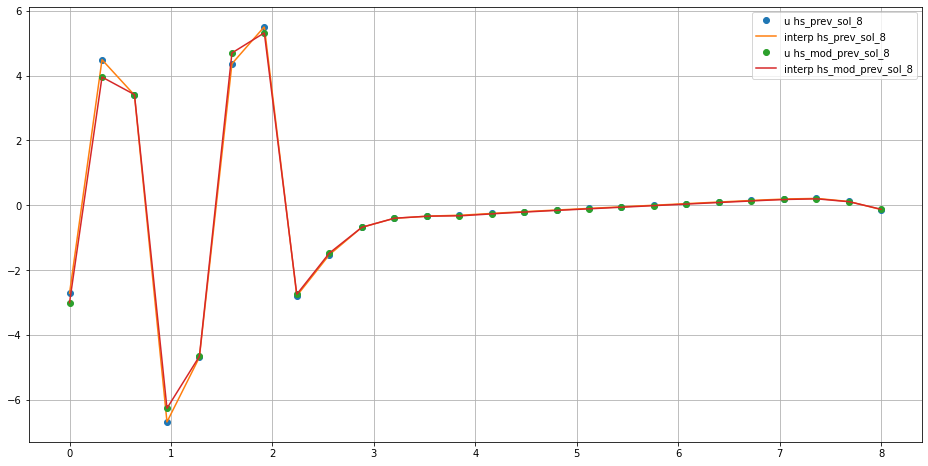

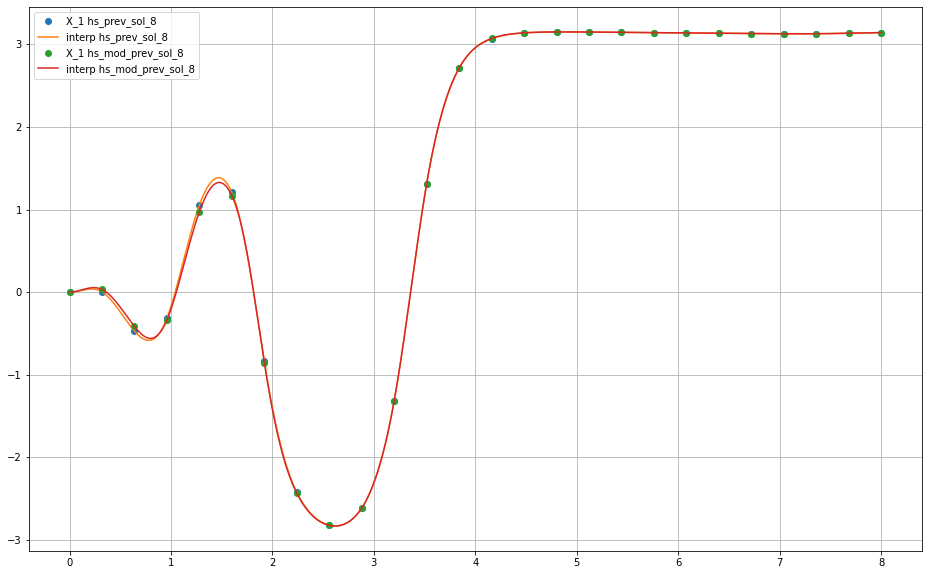

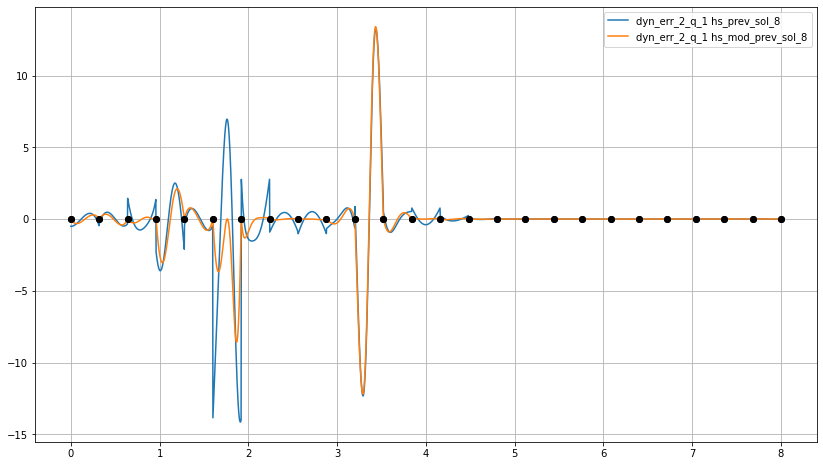

In [67]:
schemes = ['hs', 'hs_mod']#['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
initials = ['prev_sol', 'prev_sol',]#['lin', 'funcs', 'zero', 'prev_sol']
N_arr = [25, 25]#[10,15,20,25,30,40]#50,75,100,150]
t_end_values = [8,8]#[2, 4, 8]
u_schemes = ['lin', 'lin']

plt.figure(figsize=[16,8])

for jj in range(len(schemes)):
    scheme = schemes[jj]
    init = initials[jj]
    t_end = t_end_values[jj]
    N_prob = N_arr[jj]
    u_scheme = u_schemes[jj]
    
    key = f'{scheme}_{init}_{t_end}'
    xx_hs_parab_lin_int, uu_hs_parab_lin_int = interpolated_array(
        results[key][N_prob]['x'],
        results[key][N_prob]['u'],
        F = F_nump,
        h = t_end/N_prob,
        t_array = np.linspace(0, t_end, 2000),
        params = params,
        scheme = scheme,
        u_scheme = u_scheme,
        scheme_params= {'u_c':results[key][N_prob]['u_c']},
    )
    plt.plot(np.linspace(0,t_end,N_prob+1),results[key][N_prob]['u'][:], 'o',label = 'u '+key)
    if u_scheme == 'parab':
        plt.plot(np.linspace(0,t_end,2*N_prob+1)[1::2],results[key][N_prob]['u_c'][:], 'o',label = 'u_c '+key)
    plt.plot(np.linspace(0,t_end,2000),uu_hs_parab_lin_int, label = 'interp '+key)
plt.grid()
plt.legend()
ii = 1
plt.figure(figsize=[16,10])
for jj in range(len(schemes)):
    scheme = schemes[jj]
    init = initials[jj]
    t_end = t_end_values[jj]
    N_prob = N_arr[jj]
    u_scheme = u_schemes[jj]
    
    key = f'{scheme}_{init}_{t_end}'
    xx_hs_parab_lin_int, uu_hs_parab_lin_int = interpolated_array(
        results[key][N_prob]['x'],
        results[key][N_prob]['u'],
        F = F_nump,
        h = t_end/N_prob,
        t_array = np.linspace(0, t_end, 2000),
        params = params,
        scheme = scheme,
        u_scheme = u_scheme,
        scheme_params= {'u_c':results[key][N_prob]['u_c']},
    )
    plt.plot(np.linspace(0,t_end,N_prob+1),results[key][N_prob]['x'][:,ii], 'o',label = 'X_'+ str(ii)+ ' ' +key)
    plt.plot(np.linspace(0,t_end,2000),xx_hs_parab_lin_int[:,ii], label = 'interp '+key)
plt.grid()
plt.legend()

plt.figure(figsize=[14,8])
ii = 1
n_graph = 3000
for jj in range(len(schemes)):
    scheme = schemes[jj]
    init = initials[jj]
    t_end = t_end_values[jj]
    N_prob = N_arr[jj]
    u_scheme = u_schemes[jj]
    
    key = f'{scheme}_{init}_{t_end}'
    t_arr = np.linspace(0,t_end,n_graph)
    dyn_err_q, dyn_err_v, dyn_err_2_a, dyn_err_2_b = dynamic_error(
        results[key][N_prob]['x'],
        results[key][N_prob]['u'],
        t_end,
        F = F_nump,
        params = params,
        scheme = scheme,
        u_scheme = u_scheme,
        scheme_params={'u_c' : results[key][N_prob]['u_c']},
        n_interp= n_graph)


    plt.plot(t_arr,dyn_err_2_a[:,ii], '-', label = f'dyn_err_2_q_{ii} {key}')
    plt.plot(np.linspace(0,t_end,N_prob+1), np.zeros(N_prob+1), 'ok')
plt.legend()
plt.grid()

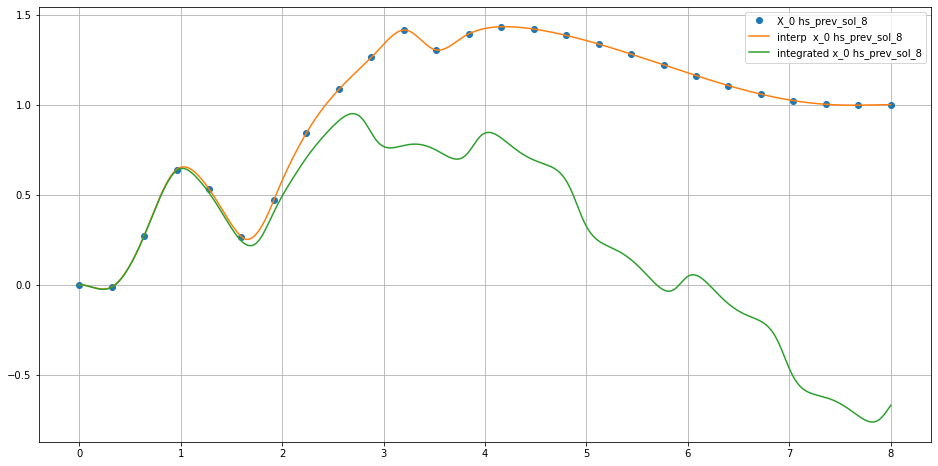

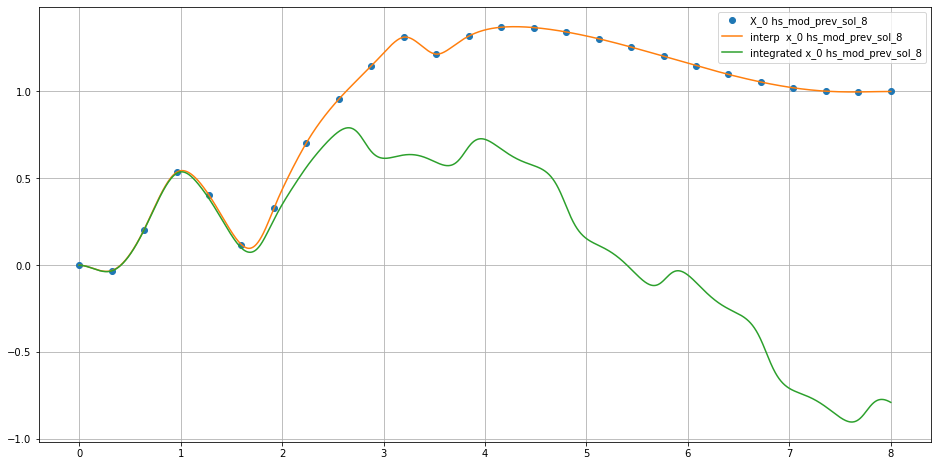

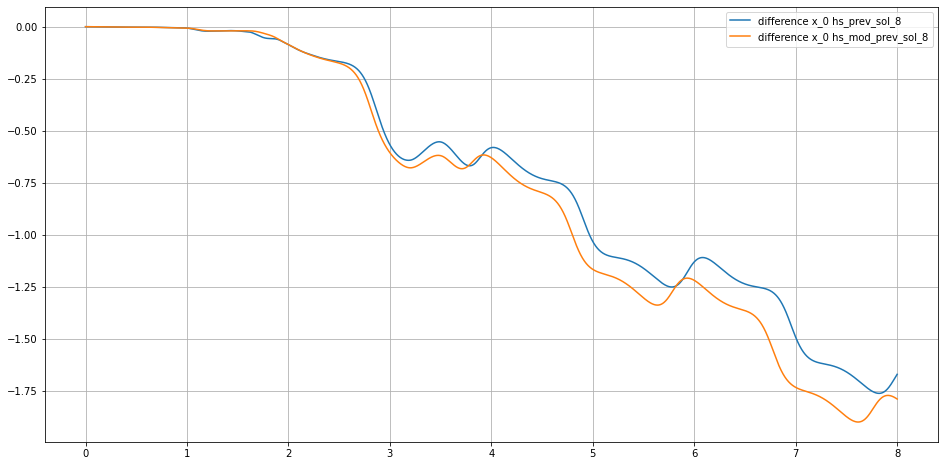

In [68]:
#Conservar valores de la celda anterior

#schemes = ['hs', 'hs_mod']#['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
#initials = ['lin', 'lin']#['lin', 'funcs']
#N_arr = [25, 25]#[10,15,20,25,30,40]#50,75,100,150]
#t_end_values = [4,4]#[2, 4, 8]
#u_schemes = ['lin', 'lin']
ii = 0
n_interp = 3000
int_errors = {}

for jj in range(len(schemes)):
    scheme = schemes[jj]
    init = initials[jj]
    t_end = t_end_values[jj]
    N_prob = N_arr[jj]
    u_scheme = u_schemes[jj]
    plt.figure(figsize=[16,8])
    
    key = f'{scheme}_{init}_{t_end}'
    xx_integr, uu_interp = integrate_cartpole_from_u(
        X_0 = results[key][N_prob]['x'][0],
        U = results[key][N_prob]['u'],
        F = F_nump,
        h = t_end/N_prob,
        params = params,
        int_fun = integrate_rk4,
        u_scheme = u_scheme,
        scheme_params = {'u_c' : results[key][N_prob]['u_c']},
        n_interp = n_interp,
    )
    xx_interpolated, uu_interpolated = interpolated_array(
        results[key][N_prob]['x'],
        results[key][N_prob]['u'],
        F = F_nump,
        h = t_end/N_prob,
        t_array = np.linspace(0, t_end, n_interp),
        params = params,
        scheme = scheme,
        u_scheme = u_scheme,
        scheme_params = {'u_c' : results[key][N_prob]['u_c']}
    )
    int_errors[key] = xx_integr-xx_interpolated
    plt.plot(np.linspace(0,t_end,N_prob+1),results[key][N_prob]['x'][:,ii], 'o',label = 'X_'+ str(ii)+ ' ' +key)
    plt.plot(np.linspace(0,t_end,n_interp),xx_interpolated[:,ii], label = f'interp  x_{ii} {key}')    
    plt.plot(np.linspace(0,t_end,n_interp),xx_integr[:,ii], label = f'integrated x_{ii} {key}')
    plt.grid()
    plt.legend()


plt.figure(figsize=[16,8])
for jj in range(len(schemes)):
    scheme = schemes[jj]
    init = initials[jj]
    t_end = t_end_values[jj]
    N_prob = N_arr[jj]
    u_scheme = u_schemes[jj]
    
    key = f'{scheme}_{init}_{t_end}'   
    plt.plot(np.linspace(0,t_end,n_interp),int_errors[key][:,ii], label = f'difference x_{ii} {key}')
plt.grid()
plt.legend()

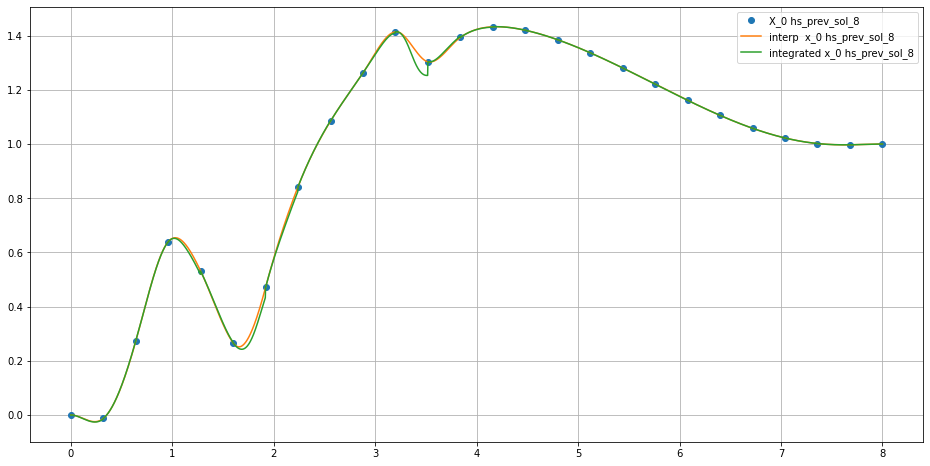

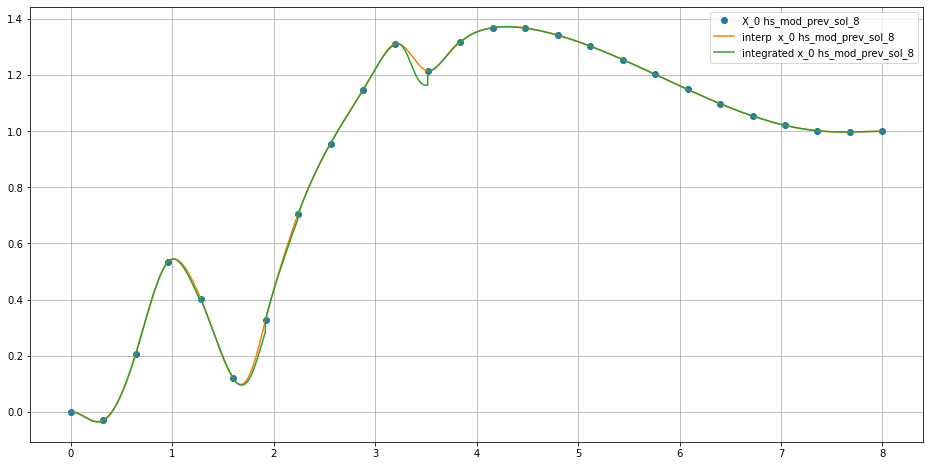

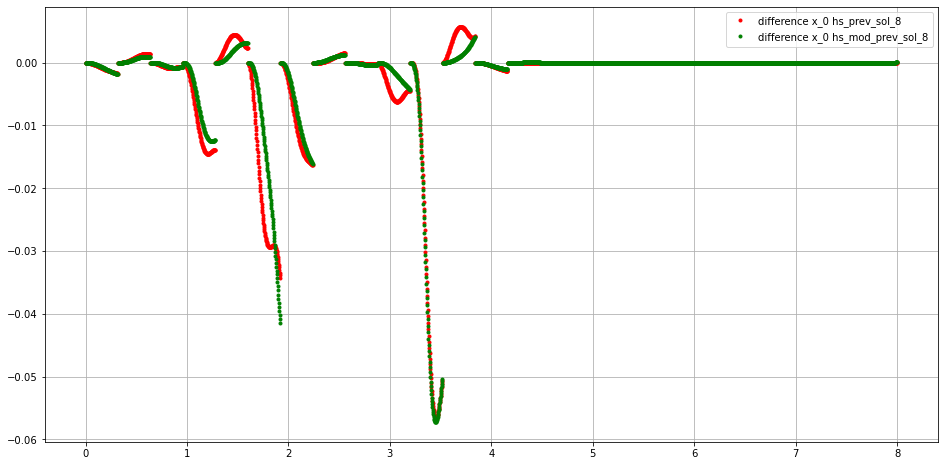

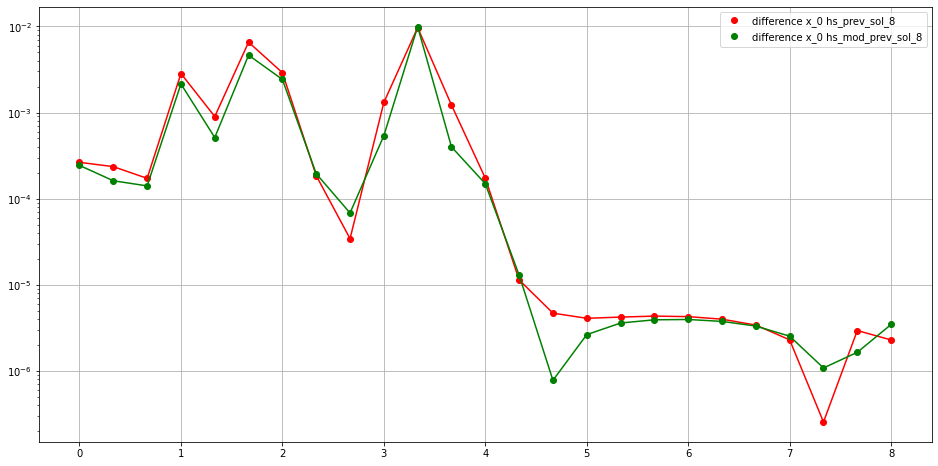

In [69]:
#Conservar valores de la celda anterior

#schemes = ['hs', 'hs_mod']#['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
#initials = ['lin', 'lin']#['lin', 'funcs']
#N_arr = [25, 25]#[10,15,20,25,30,40]#50,75,100,150]
#t_end_values = [4,4]#[2, 4, 8]
#u_schemes = ['lin', 'lin']
ii = 0
n_interp = 3000
int_errors = {}
segmented_errors = {}
colors = ['r','g','b', 'orange']

for jj in range(len(schemes)):
    scheme = schemes[jj]
    init = initials[jj]
    t_end = t_end_values[jj]
    N_prob = N_arr[jj]
    u_scheme = u_schemes[jj]
    plt.figure(figsize=[16,8])
    
    key = f'{scheme}_{init}_{t_end}'
    xx_interpolated, uu_interpolated, xx_integr, akk_diff =integrate_cartpole_segmented(
        X = results[key][N_prob]['x'],
        U = results[key][N_prob]['u'],
        F = F_nump,
        h = t_end/N_prob,
        params = params,
        int_fun = integrate_rk4,
        scheme = scheme,
        u_scheme = u_scheme,
        scheme_params = {'u_c' : results[key][N_prob]['u_c']},
        n_interp = n_interp,
    )
    n_plot = xx_interpolated.shape[0]
    int_errors[key] = xx_integr-xx_interpolated
    segmented_errors[key] = akk_diff
    plt.plot(np.linspace(0,t_end,N_prob+1),results[key][N_prob]['x'][:,ii], 'o',label = 'X_'+ str(ii)+ ' ' +key)
    plt.plot(np.linspace(0,t_end,n_plot),xx_interpolated[:,ii], label = f'interp  x_{ii} {key}')    
    plt.plot(np.linspace(0,t_end,n_plot),xx_integr[:,ii], label = f'integrated x_{ii} {key}')
    plt.grid()
    plt.legend()


plt.figure(figsize=[16,8])
for jj in range(len(schemes)):
    scheme = schemes[jj]
    init = initials[jj]
    t_end = t_end_values[jj]
    N_prob = N_arr[jj]
    u_scheme = u_schemes[jj]
    
    key = f'{scheme}_{init}_{t_end}'   
    plt.plot(np.linspace(0,t_end,n_plot),int_errors[key][:,ii],'.', color = colors[jj], label = f'difference x_{ii} {key}')
plt.grid()
plt.legend()

plt.figure(figsize=[16,8])
for jj in range(len(schemes)):
    scheme = schemes[jj]
    init = initials[jj]
    t_end = t_end_values[jj]
    N_prob = N_arr[jj]
    u_scheme = u_schemes[jj]
    
    key = f'{scheme}_{init}_{t_end}'   
    plt.plot(np.linspace(0,t_end,N_prob),segmented_errors[key][:,ii], 'o', color = colors[jj], label = f'difference x_{ii} {key}')
    plt.plot(np.linspace(0,t_end,N_prob),segmented_errors[key][:,ii], color = colors[jj])
plt.grid()
plt.legend()
plt.yscale('log')

In [70]:
def calculate_integrated_errors(X,U,F,t_end,params, scheme, u_scheme, scheme_params, n_interp,int_fun = integrate_rk4):
    N_prob = X.shape[0]
    dyn_err_q, dyn_err_v, dyn_err_2_a, dyn_err_2_b = dynamic_error(
        X,
        U,
        t_end, 
        F = F,
        params = params,
        scheme = scheme,
        u_scheme = u_scheme,
        scheme_params = scheme_params,
        n_interp = n_interp)
    t_array = np.linspace(0,t_end, n_interp)
    dyn_err_q_integ = np.sum(np.trapz(np.abs(dyn_err_q), t_array, axis = 0))
    dyn_err_v_integ = np.sum(np.trapz(np.abs(dyn_err_v), t_array, axis = 0))
    dyn_err_2_integ = np.sum(np.trapz(np.abs(dyn_err_2_a), t_array, axis = 0))
    
    xx_interpolated, uu_interpolated, xx_integr, akk_diff =integrate_cartpole_segmented(
        X,
        U,
        F,
        t_end/N_prob,
        params,
        int_fun,
        scheme,
        u_scheme,
        scheme_params,
        n_interp,
    )
    dev_integ = np.sum(akk_diff)*t_end/N_prob
    return dyn_err_q_integ, dyn_err_v_integ, dyn_err_2_integ, dev_integ

In [71]:
list(calculate_integrated_errors(
    X = results[key][N_prob]['x'],
    U = results[key][N_prob]['u'],
    F = F_nump,
    t_end = t_end,
    params = params,
    scheme = scheme,
    u_scheme = u_scheme,
    scheme_params = {'u_c' : results[key][N_prob]['u_c']},
    n_interp = 3000,
    int_fun = integrate_rk4))

In [72]:
schemes = ['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
init = 'prev_sol'
N_arr = [10,15,20,25,30,40,50,75,100,150]
t_end_values = [2, 4, 8]

integ_errors_dict = {}

for scheme in schemes:
    for t_end in t_end_values:
        key = f'{scheme}_{init}_{t_end}'
        print('Problem:', key)
        if 'parab' in scheme:
            u_scheme = 'parab'
        else:
            u_scheme = 'lin'
        err_table = []
        for N in N_arr:
            print(f'\tN = {N}')
            errors = list(calculate_integrated_errors(
                X = results[key][N]['x'],
                U = results[key][N]['u'],
                F = F_nump,
                t_end = t_end,
                params = params,
                scheme = scheme,
                u_scheme = u_scheme,
                scheme_params = {'u_c':results[key][N]['u_c']},
                n_interp = 3000,
                int_fun = integrate_rk4))
            err_table.append(errors)
        integ_errors_dict[key] = np.array(err_table)

Problem: hs_prev_sol_2
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_prev_sol_4
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_prev_sol_8
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_mod_prev_sol_2
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_mod_prev_sol_4
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_mod_prev_sol_8
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_parab_prev_sol_2
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_parab_prev_sol_4
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75


KeyboardInterrupt: 

In [ ]:
t_end = 4
schemes = ['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
init = 'prev_sol'
titles = ['accumulated dynamic error in q',
          'accumulated dynamic error in v',
          'accumulated second order dynamic error',
          'accumulated segmented deviation error']

for ii in range(4):
    plt.figure(figsize=[15,10])
    for scheme in schemes:
        key = f'{scheme}_{init}_{t_end}'
        nn = results[key]['N_arr']
        plt.plot(nn, integ_errors_dict[key][:,ii], label = scheme)
    plt.title(f'{titles[ii]}, t_end = {t_end} s')
    plt.grid()
    plt.legend()
    plt.yscale('log')

## Pseudoinverse Dynamics

In [ ]:
key = 'hs_mod_parab_prev_sol_8'
N_prob = 25
t_end = 8
xx_int, uu_pinv_int = interpolated_array(
    results[key][N_prob]['x'],
    results[key][N_prob]['u'],
    F = F_nump,
    h = t_end/N_prob,
    t_array = np.linspace(0, t_end, 2000),
    params = params,
    scheme = "hs_mod_parab",
    u_scheme='pinv_dyn',
    scheme_params={'u_c' : results[key][N_prob]['u_c'],
    'pinv_f': num_pinv_dyn}
)

In [ ]:
key = 'hs_mod_parab_prev_sol_8'
N_prob = 25
t_end = 8
xx_int, uu_int = interpolated_array(
    results[key][N_prob]['x'],
    results[key][N_prob]['u'],
    F = F_nump,
    h = t_end/N_prob,
    t_array = np.linspace(0, t_end, 2000),
    params = params,
    scheme = "hs_mod_parab",
    u_scheme = 'parab',
    scheme_params = {'u_c' : results[key][N_prob]['u_c']}
)

In [ ]:

plt.figure(figsize=[16,8])
plt.plot(np.linspace(0,t_end,N_prob+1),results[key][N_prob]['u'][:], 'o',label = 'u Siro')
plt.plot(np.linspace(0,t_end,2*N_prob+1)[1::2],results[key][N_prob]['u_c'][:], 'o',label = 'u_c Siro')
plt.plot(np.linspace(0,t_end,2000),uu_pinv_int[:], label = 'interpolation inv dyn')
plt.plot(np.linspace(0,t_end,2000),uu_int[:], label = 'interpolation parab')
plt.grid()
plt.legend()

In [ ]:

plt.figure(figsize=[16,8])
plt.plot(np.linspace(0,t_end,N_prob+1),results[key][N_prob]['x'][:], 'o',label = 'x Siro')
#plt.plot(np.linspace(0,t_end,2*N_prob+1)[1::2],results[key][N_prob]['u_c'][:], 'o',label = 'u_c Siro')
plt.plot(np.linspace(0,t_end,2000),xx_int[:], label = 'interpolation parab')
plt.grid()
plt.legend()

In [60]:
n_graph = 1000
t_end = 8
t_arr = np.linspace(0,t_end,n_graph)
key = 'hs_mod_prev_sol_8'
dyn_err_q, dyn_err_v, dyn_err_2_a, dyn_err_2_b = dynamic_error(
    results[key][25]['x'],
    results[key][25]['u'],
    2,
    F = F_nump,
    params = params,
    scheme = 'hs_mod', 
    u_scheme='lin',
    scheme_params={'u_c':results[key][25]['u_c']},
    n_interp= n_graph)

dyn_err_q_pinv, dyn_err_v_pinv, dyn_err_2_a_pinv, dyn_err_2_b_pinv = dynamic_error(
    results[key][25]['x'],
    results[key][25]['u'],
    2,
    F = F_nump,
    params = params,
    scheme = 'hs_mod', 
    u_scheme='pinv_dyn',
    scheme_params={'u_c':results[key][25]['u_c'],
    'pinv_f': num_pinv_dyn},
    n_interp= n_graph)



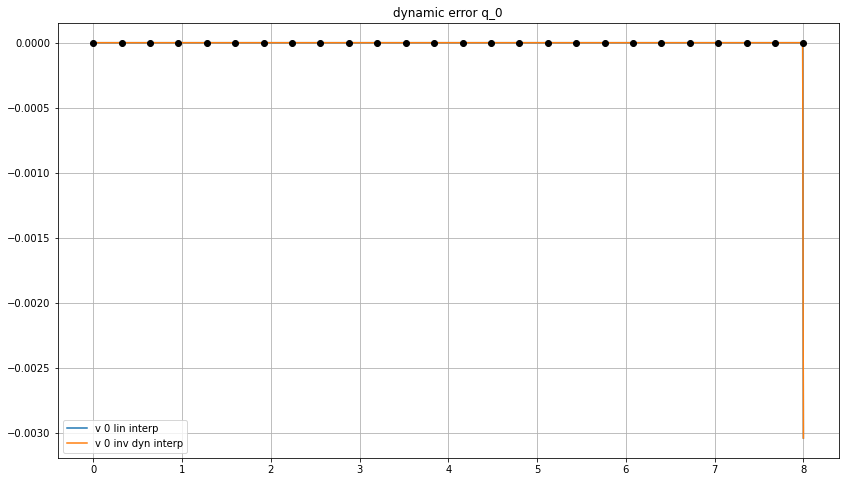

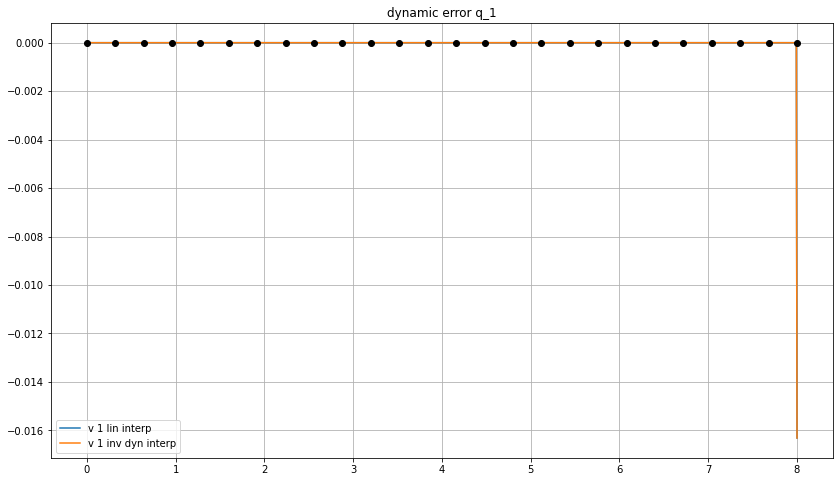

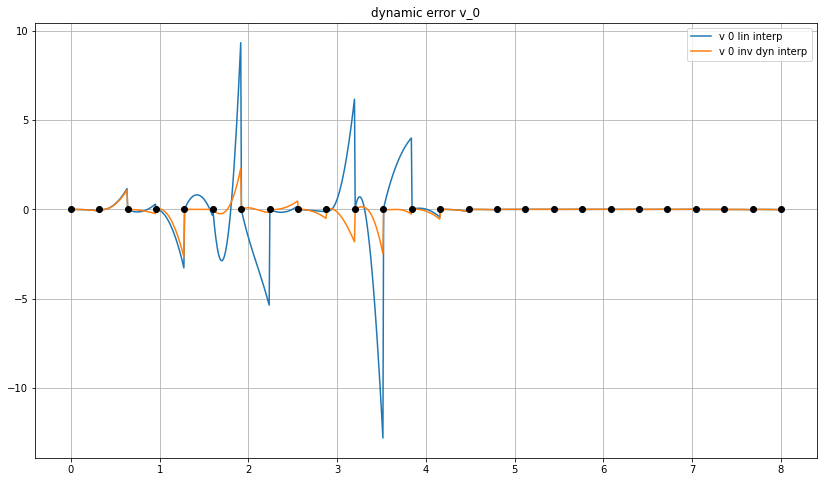

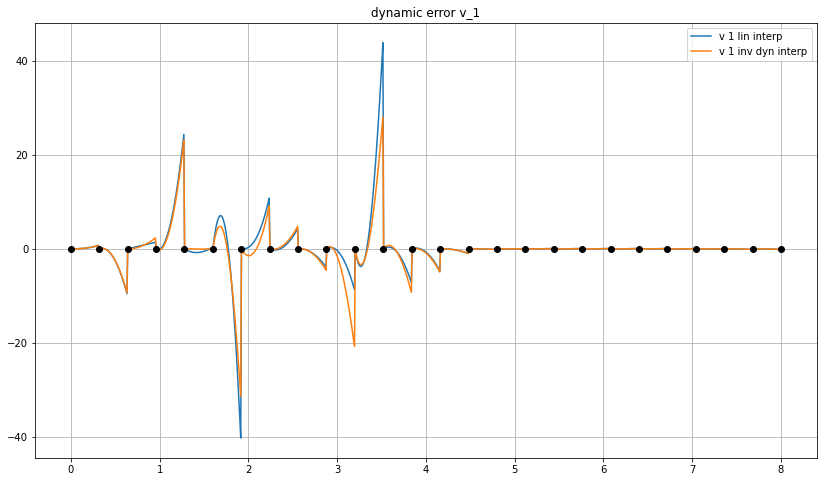

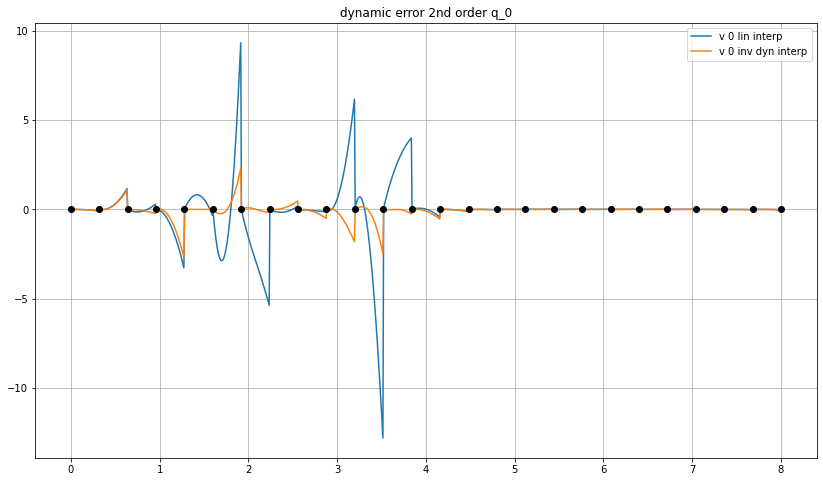

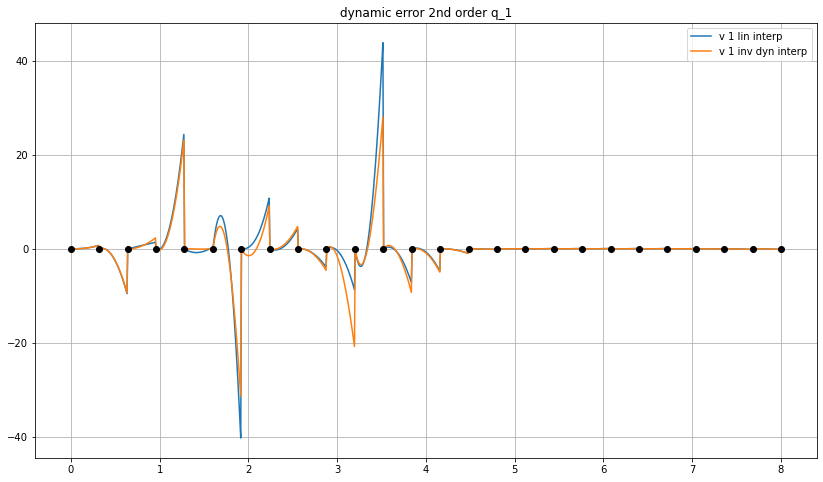

In [61]:
for ii in range(2):
    plt.figure(figsize=[14,8])
    plt.plot(t_arr,-dyn_err_q[:,ii], '-', label = f'v {ii} lin interp')
    plt.plot(t_arr,-dyn_err_q_pinv[:,ii], '-', label = f'v {ii} inv dyn interp')
    plt.plot(np.linspace(0,t_end,26), np.zeros(26), 'ok')
    plt.legend()
    plt.grid()
    plt.title(f'dynamic error q_{ii}')
    
for ii in range(2):
    plt.figure(figsize=[14,8])
    plt.plot(t_arr,-dyn_err_v[:,ii], '-', label = f'v {ii} lin interp')
    plt.plot(t_arr,-dyn_err_v_pinv[:,ii], '-', label = f'v {ii} inv dyn interp')
    plt.plot(np.linspace(0,t_end,26), np.zeros(26), 'ok')
    plt.legend()
    plt.grid()
    plt.title(f'dynamic error v_{ii}')
    
for ii in range(2):
    plt.figure(figsize=[14,8])
    plt.plot(t_arr,-dyn_err_2_a[:,ii], '-', label = f'v {ii} lin interp')
    plt.plot(t_arr,-dyn_err_2_a_pinv[:,ii], '-', label = f'v {ii} inv dyn interp')
    plt.plot(np.linspace(0,t_end,26), np.zeros(26), 'ok')
    plt.legend()
    plt.grid()
    plt.title(f'dynamic error 2nd order q_{ii}')


In [62]:
schemes = ['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
init = 'prev_sol'
N_arr = [10,15,20,25,30,40,50,75,100,150]
t_end_values = [2, 4, 8]


for scheme in schemes:
    for t_end in t_end_values:
        key = f'{scheme}_{init}_{t_end}'
        new_key = key +'_pinv'
        print('Problem:', key)
        u_scheme = 'pinv_dyn'
        err_table = []
        for N in N_arr:
            print(f'\tN = {N}')
            errors = list(calculate_integrated_errors(
                X = results[key][N]['x'],
                U = results[key][N]['u'],
                F = F_nump,
                t_end = t_end,
                params = params,
                scheme = scheme,
                u_scheme = u_scheme,
                scheme_params = {'u_c':results[key][N]['u_c'],
                                'pinv_f': num_pinv_dyn},
                n_interp = 3000,
                int_fun = integrate_rk4))
            err_table.append(errors)
        integ_errors_dict[new_key] = np.array(err_table)

Problem: hs_prev_sol_2
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_prev_sol_4
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_prev_sol_8
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_mod_prev_sol_2
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_mod_prev_sol_4
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_mod_prev_sol_8
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_parab_prev_sol_2
	N = 10


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_parab_prev_sol_4
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_parab_prev_sol_8
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_mod_parab_prev_sol_2
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_mod_parab_prev_sol_4
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_mod_parab_prev_sol_8
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150


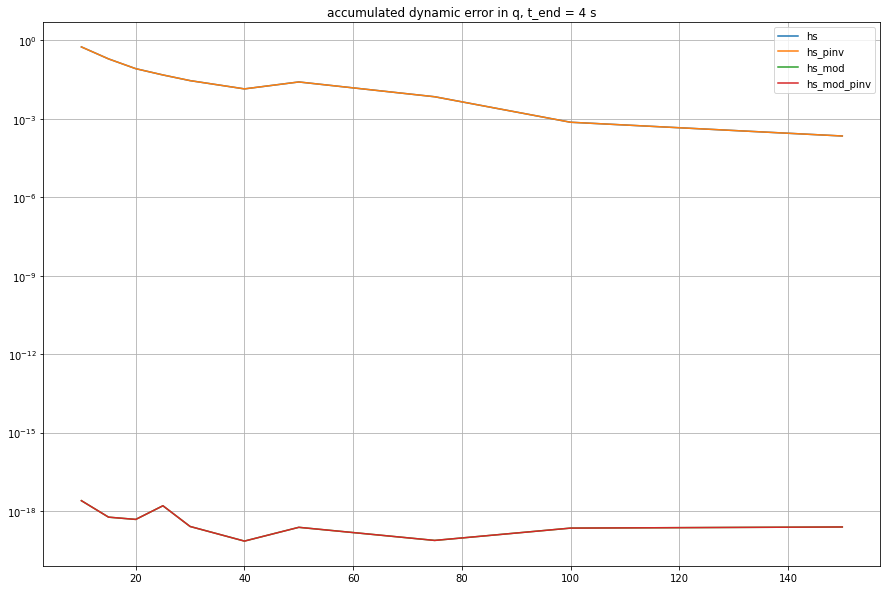

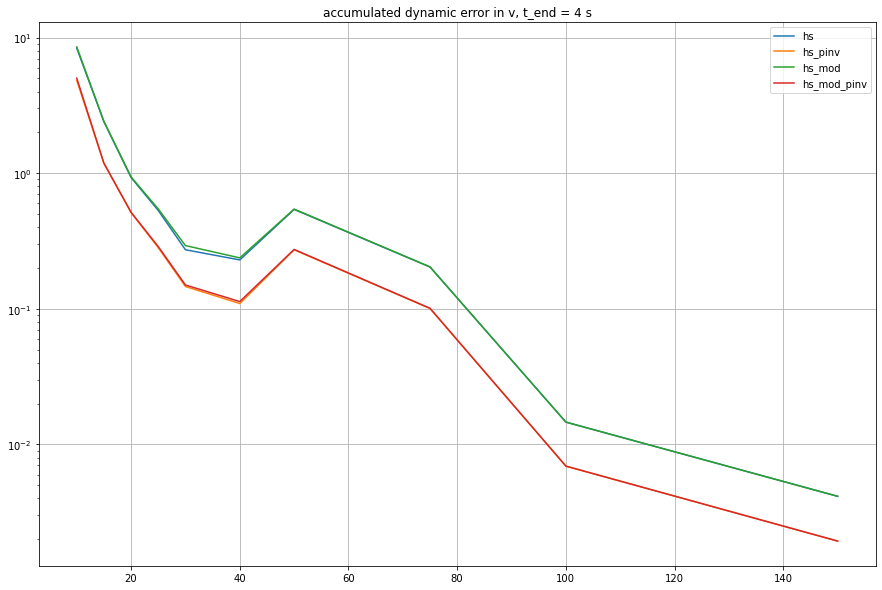

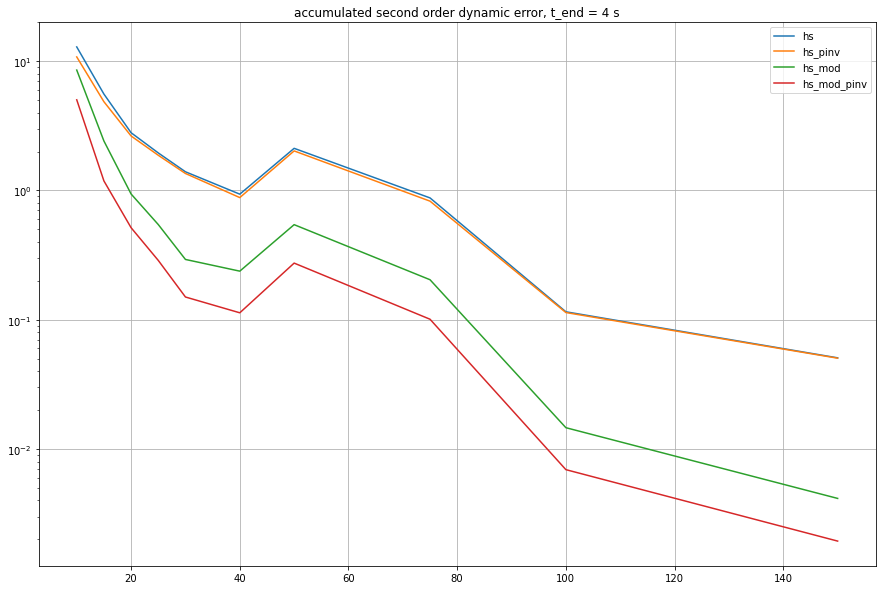

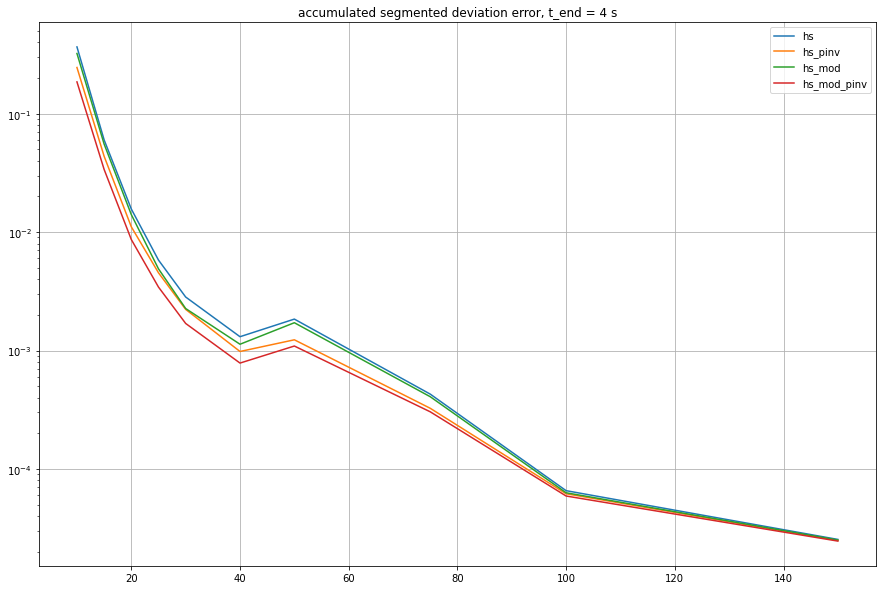

In [63]:
t_end = 4
schemes = ['hs', 'hs_mod']#, 'hs_parab', 'hs_mod_parab']
init = 'prev_sol'
titles = ['accumulated dynamic error in q',
          'accumulated dynamic error in v',
          'accumulated second order dynamic error',
          'accumulated segmented deviation error']

for ii in range(4):
    plt.figure(figsize=[15,10])
    for scheme in schemes:
        key = f'{scheme}_{init}_{t_end}'
        nn = results[key]['N_arr']
        plt.plot(nn, integ_errors_dict[key][:,ii], label = scheme)
        new_key = key +'_pinv'
        plt.plot(nn, integ_errors_dict[new_key][:,ii], label = scheme+ '_pinv')
    plt.title(f'{titles[ii]}, t_end = {t_end} s')
    plt.grid()
    plt.legend()
    plt.yscale('log')

## Minimal error u interpolation

In [65]:
key = 'hs_mod_lin_8'
t_end =8
N_prob = 25
xx_int, uu_min_err_int = interpolated_array(
    results[key][N_prob]['x'],
    results[key][N_prob]['u'],
    F = F_nump,
    h = t_end/N_prob,
    t_array = np.linspace(0, t_end, 2000),
    params = params,
    scheme = "hs_mod",
    u_scheme = 'min_err',
    scheme_params = {'u_c' : results[key][N_prob]['u_c']}
)

In [67]:
key = 'hs_mod_lin_8'
t_end =8
N_prob = 25
xx_int, uu_int = interpolated_array(
    results[key][N_prob]['x'],
    results[key][N_prob]['u'],
    F = F_nump,
    h = t_end/N_prob,
    t_array = np.linspace(0, t_end, 2000),
    params = params,
    scheme = "hs_mod",
    u_scheme = 'lin',
    scheme_params={'u_c' : results[key][N_prob]['u_c']}
)

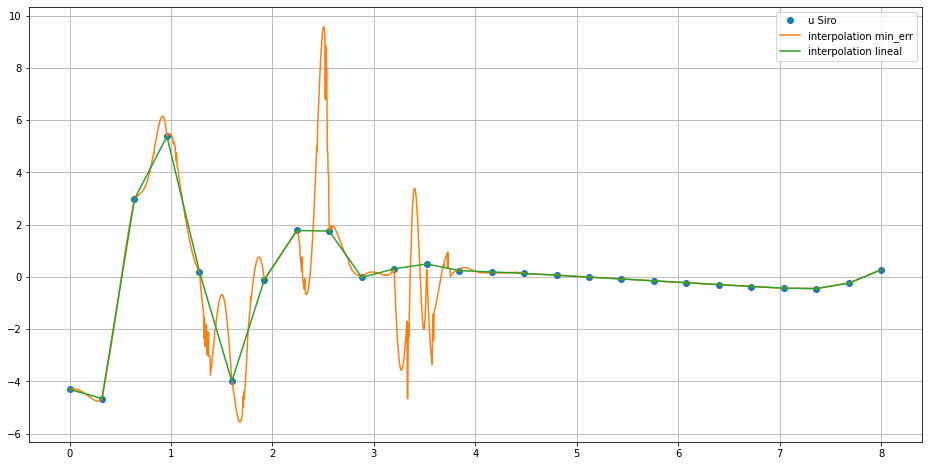

In [68]:
plt.figure(figsize=[16,8])
plt.plot(np.linspace(0,t_end,N_prob+1),results[key][N_prob]['u'][:], 'o',label = 'u Siro')
#plt.plot(np.linspace(0,t_end,2*N_prob+1)[1::2],results[key][N_prob]['u_c'][:], 'o',label = 'u_c Siro')
plt.plot(np.linspace(0,t_end,2000),uu_min_err_int, label = 'interpolation min_err')
plt.plot(np.linspace(0,t_end,2000),uu_int, label = 'interpolation lineal')
plt.grid()
plt.legend()

In [70]:
key = 'hs_mod_lin_8'
t_end =8
N_prob = 25
xx_int, uu_pinv_int = interpolated_array(
    results[key][N_prob]['x'],
    results[key][N_prob]['u'],
    F = F_nump,
    h = t_end/N_prob,
    t_array = np.linspace(0, t_end, 2000),
    params = params,
    scheme = "hs_mod",
    u_scheme='pinv_dyn',
    scheme_params={'u_c' : results[key][N_prob]['u_c'],
    'pinv_f': num_pinv_dyn}
)

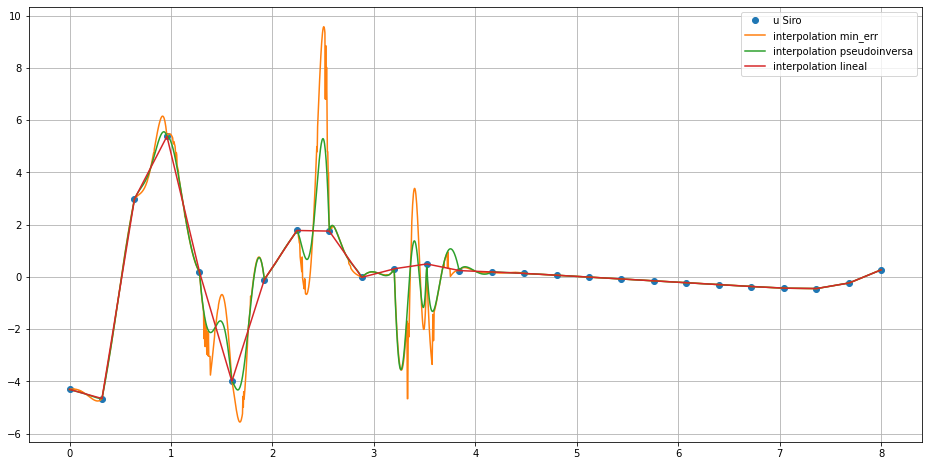

In [71]:
plt.figure(figsize=[16,8])
plt.plot(np.linspace(0,t_end,N_prob+1),results[key][N_prob]['u'][:], 'o',label = 'u Siro')
#plt.plot(np.linspace(0,t_end,2*N_prob+1)[1::2],results[key][N_prob]['u_c'][:], 'o',label = 'u_c Siro')
plt.plot(np.linspace(0,t_end,2000),uu_min_err_int, label = 'interpolation min_err')
plt.plot(np.linspace(0,t_end,2000),uu_pinv_int, label = 'interpolation pseudoinversa')
plt.plot(np.linspace(0,t_end,2000),uu_int, label = 'interpolation lineal')
plt.grid()
plt.legend()

In [73]:
n_graph = 1000
t_arr = np.linspace(0,t_end,n_graph)
key = 'hs_mod_prev_sol_8'
dyn_err_q, dyn_err_v, dyn_err_2_a, dyn_err_2_b = dynamic_error(
    results[key][25]['x'],
    results[key][25]['u'],
    2,
    F = F_nump,
    params = params,
    scheme = 'hs_mod', 
    u_scheme='lin',
    scheme_params={'u_c':results[key][25]['u_c']},
    n_interp= n_graph)

dyn_err_q_min_err, dyn_err_v_min_err, dyn_err_2_a_min_err, dyn_err_2_b_min_err = dynamic_error(
    results[key][25]['x'],
    results[key][25]['u'],
    2,
    F = F_nump,
    params = params,
    scheme = 'hs_mod', 
    u_scheme='min_err',
    scheme_params={'u_c':results[key][25]['u_c']},
    n_interp= n_graph)

dyn_err_q_pinv, dyn_err_v_pinv, dyn_err_2_a_pinv, dyn_err_2_b_pinv = dynamic_error(
    results[key][25]['x'], 
    results[key][25]['u'],
    2,
    F = F_nump,
    params = params,
    scheme = 'hs_mod', 
    u_scheme='pinv_dyn',
    scheme_params={'u_c':results[key][25]['u_c'],
    'pinv_f': num_pinv_dyn},
    n_interp= n_graph)

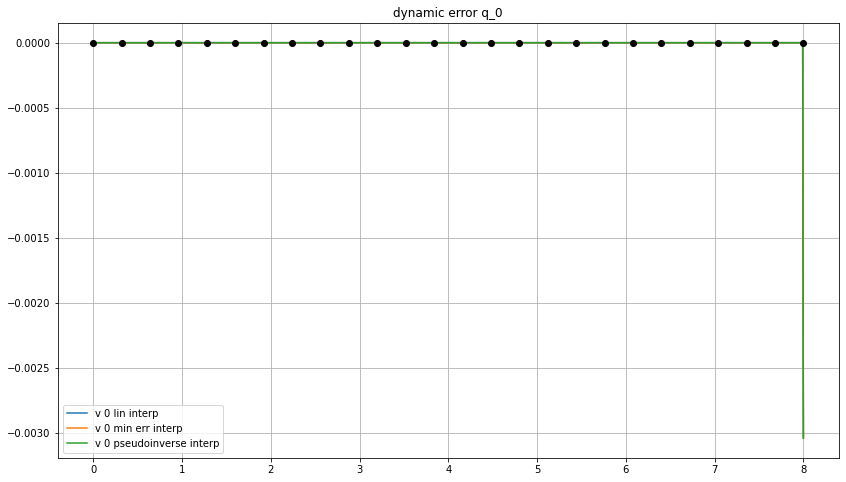

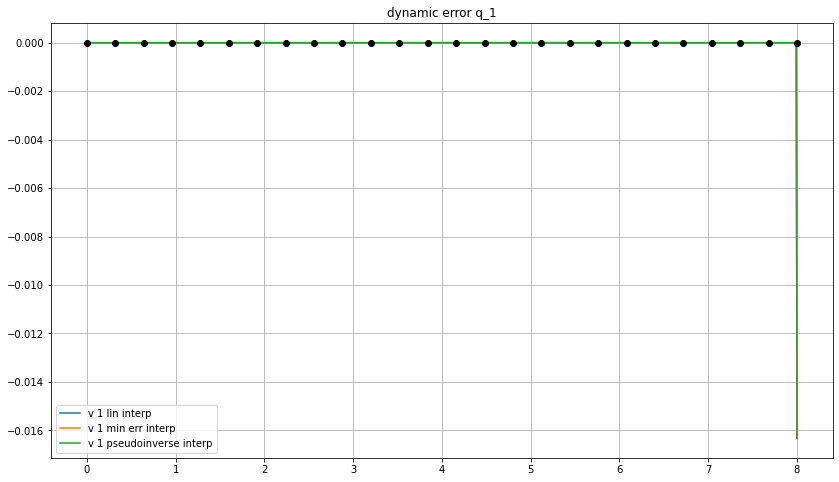

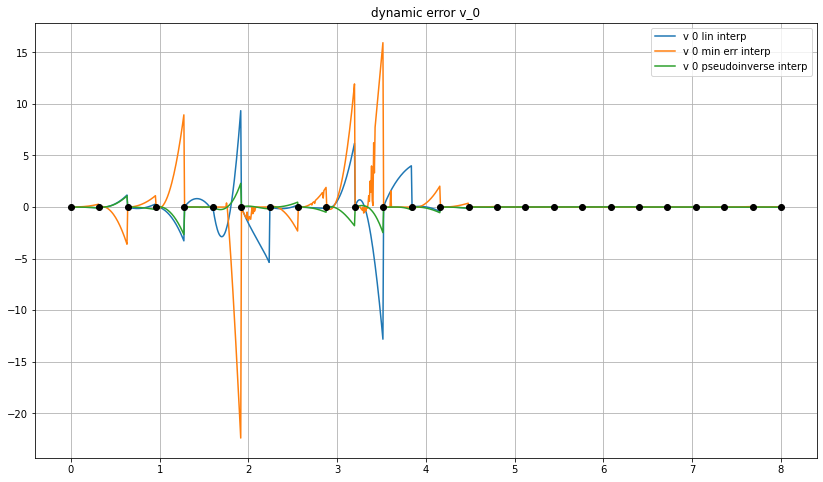

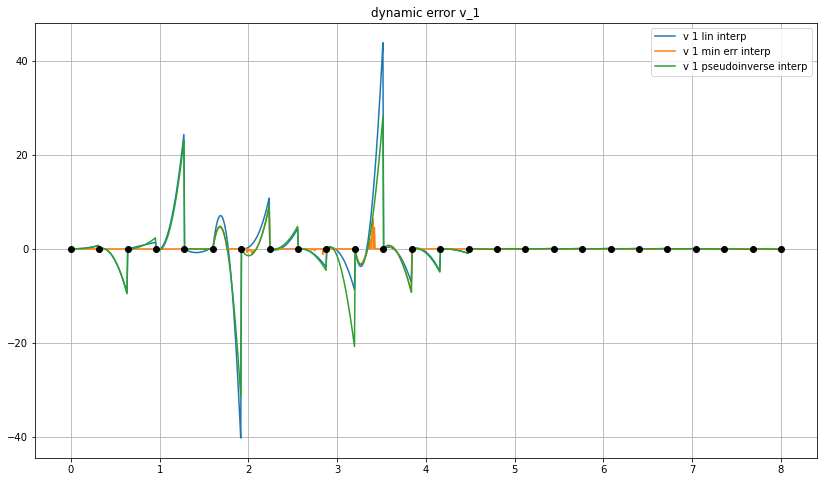

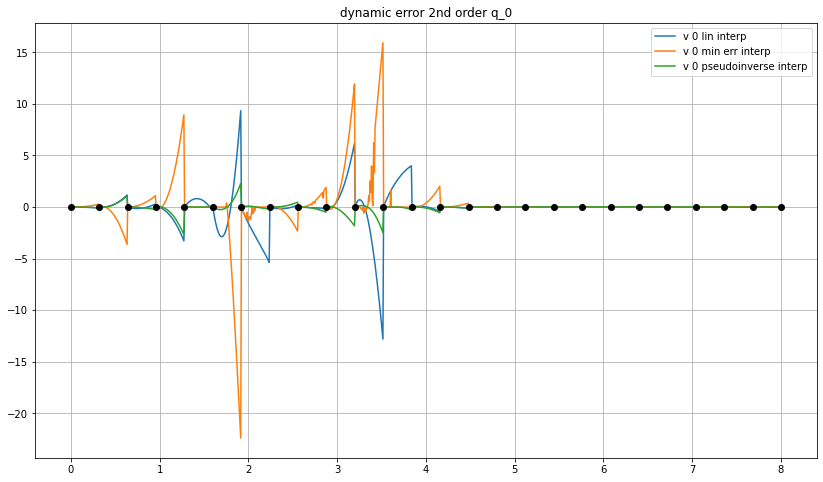

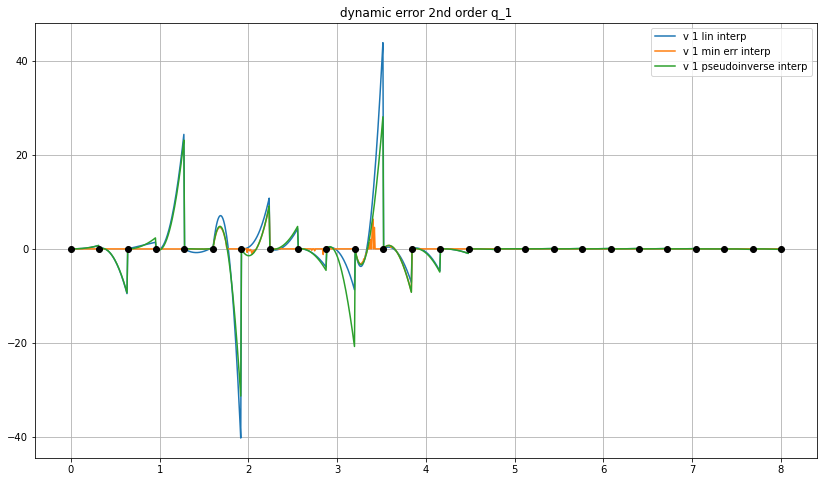

In [74]:
for ii in range(2):
    plt.figure(figsize=[14,8])
    plt.plot(t_arr,-dyn_err_q[:,ii], '-', label = f'v {ii} lin interp')
    plt.plot(t_arr,-dyn_err_q_min_err[:,ii], '-', label = f'v {ii} min err interp')
    plt.plot(t_arr,-dyn_err_q_pinv[:,ii], '-', label = f'v {ii} pseudoinverse interp')
    plt.plot(np.linspace(0,t_end,26), np.zeros(26), 'ok')
    plt.legend()
    plt.grid()
    plt.title(f'dynamic error q_{ii}')
    
for ii in range(2):
    plt.figure(figsize=[14,8])
    plt.plot(t_arr,-dyn_err_v[:,ii], '-', label = f'v {ii} lin interp')
    plt.plot(t_arr,-dyn_err_v_min_err[:,ii], '-', label = f'v {ii} min err interp')
    plt.plot(t_arr,-dyn_err_v_pinv[:,ii], '-', label = f'v {ii} pseudoinverse interp')
    plt.plot(np.linspace(0,t_end,26), np.zeros(26), 'ok')
    plt.legend()
    plt.grid()
    plt.title(f'dynamic error v_{ii}')
    
for ii in range(2):
    plt.figure(figsize=[14,8])
    plt.plot(t_arr,-dyn_err_2_a[:,ii], '-', label = f'v {ii} lin interp')
    plt.plot(t_arr,-dyn_err_2_a_min_err[:,ii], '-', label = f'v {ii} min err interp')
    plt.plot(t_arr,-dyn_err_2_a_pinv[:,ii], '-', label = f'v {ii} pseudoinverse interp')
    plt.plot(np.linspace(0,t_end,26), np.zeros(26), 'ok')
    plt.legend()
    plt.grid()
    plt.title(f'dynamic error 2nd order q_{ii}')

In [84]:
results[key][N_prob]

{'x': array([[ 0.00000000e+00, -1.91999370e-34,  0.00000000e+00,
         -2.44096574e-32],
        [-3.08413164e-02,  3.40250736e-02,  1.83678592e-01,
         -5.75563528e-01],
        [ 2.05522612e-01, -4.14526172e-01,  1.18848343e+00,
         -1.54203531e+00],
        [ 5.34876040e-01, -3.36621597e-01,  3.66296779e-01,
          2.89758931e+00],
        [ 4.03385270e-01,  9.74602851e-01, -8.76449040e-01,
          3.43589138e+00],
        [ 1.18589272e-01,  1.16712551e+00, -5.36618051e-01,
         -2.64456378e+00],
        [ 3.28155660e-01, -8.56883060e-01,  1.41872690e+00,
         -7.84212866e+00],
        [ 7.04304454e-01, -2.43302530e+00,  9.85215478e-01,
         -2.43870742e+00],
        [ 9.56192433e-01, -2.82312981e+00,  6.46262141e-01,
         -2.77890923e-01],
        [ 1.14730547e+00, -2.61340229e+00,  5.96165054e-01,
          1.87667984e+00],
        [ 1.31273339e+00, -1.31266888e+00,  8.84679282e-02,
          6.87858305e+00],
        [ 1.21501788e+00,  1.31506824e

In [85]:
from optibot.schemes import hs_mod_midpoint

In [90]:
key = 'hs_mod_prev_sol_8'
t_end = 8
N_prob = 25

_X_dot= np.array([list(F_nump(
    results[key][N_prob]['x'][ii],
    results[key][N_prob]['u'][ii],
    params
)) for ii in range(results[key][N_prob]['x'].shape[0])])

_X_c = np.array([list(hs_mod_midpoint(
    results[key][N_prob]['x'][ii],
    results[key][N_prob]['x'][ii + 1],
    _X_dot[ii],
    _X_dot[ii + 1],
    t_end/N_prob,
    params,
))for ii in range(results[key][N_prob]['x'].shape[0] - 1)])

_u_c = (results[key][N_prob]['u'][:-1]+results[key][N_prob]['u'][1:])/2

_X_dot_c= np.array([list(F_nump(
    _X_c[ii],
    _u_c[ii],
    params
)) for ii in range(_u_c.shape[0])])

xx_integr_min_err, uu_integr_min_err = integrate_cartpole_from_u(
        X_0 = results[key][N_prob]['x'][0],
        U = results[key][N_prob]['u'],#uu_min_err_int,
        F = F_nump,
        h = t_end/N_prob,
        params = params,
        int_fun = integrate_rk4,
        u_scheme = 'min_err',
        scheme_params = {'u_c':_u_c,
                        'F': F_nump,
                        'scheme': 'hs_mod',
                        'X':results[key][N_prob]['x'],
                        'params':params,
                        'X_dot': _X_dot,
                        'x_dot_c': _X_dot_c},
        n_interp = 2000,
    )



xx_integr_lin, uu_integr_lin = integrate_cartpole_from_u(
        X_0 = results[key][N_prob]['x'][0],
        U = results[key][N_prob]['u'],
        F = F_nump,
        h = t_end/N_prob,
        params = params,
        int_fun = integrate_rk4,
        u_scheme = 'lin',
        scheme_params = {'u_c':_u_c,
                        'F': F_nump,
                        'scheme': 'hs_mod',
                        'X':results[key][N_prob]['x'],
                        'params':params,
                        'X_dot': _X_dot,
                        'x_dot_c': _X_dot_c},
        n_interp = 2000,
    )

xx_integr_pinv, uu_integr_pinv = integrate_cartpole_from_u(
        X_0 = results[key][N_prob]['x'][0],
        U = results[key][N_prob]['u'],#uu_min_err_int,
        F = F_nump,
        h = t_end/N_prob,
        params = params,
        int_fun = integrate_rk4,
        u_scheme = 'pinv_dyn',
        scheme_params = {'u_c':_u_c,
                        'F': F_nump,
                        'scheme': 'hs_mod',
                        'X':results[key][N_prob]['x'],
                        'params':params,
                        'pinv_f': num_pinv_dyn,
                        'X_dot': _X_dot,
                        'x_dot_c': _X_dot_c},
        n_interp = 2000,
    )

xx_int, uu_int = interpolated_array(
    results[key][N_prob]['x'],
    results[key][N_prob]['u'],
    F = F_nump,
    h = t_end/N_prob,
    t_array = np.linspace(0, t_end, 2000),
    params = params,
    scheme = "hs_mod",
    u_scheme = 'lin',
    scheme_params={'u_c' : _u_c}
)

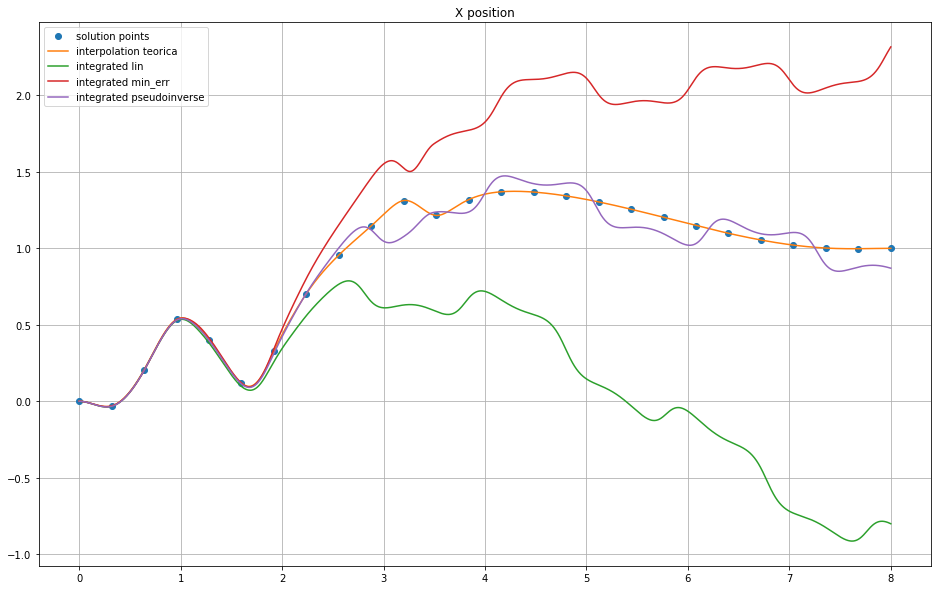

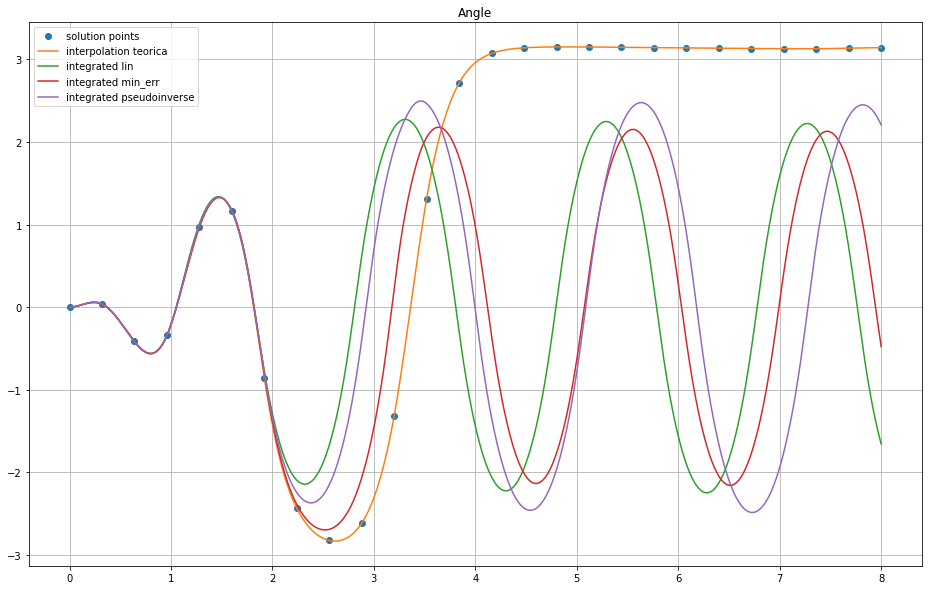

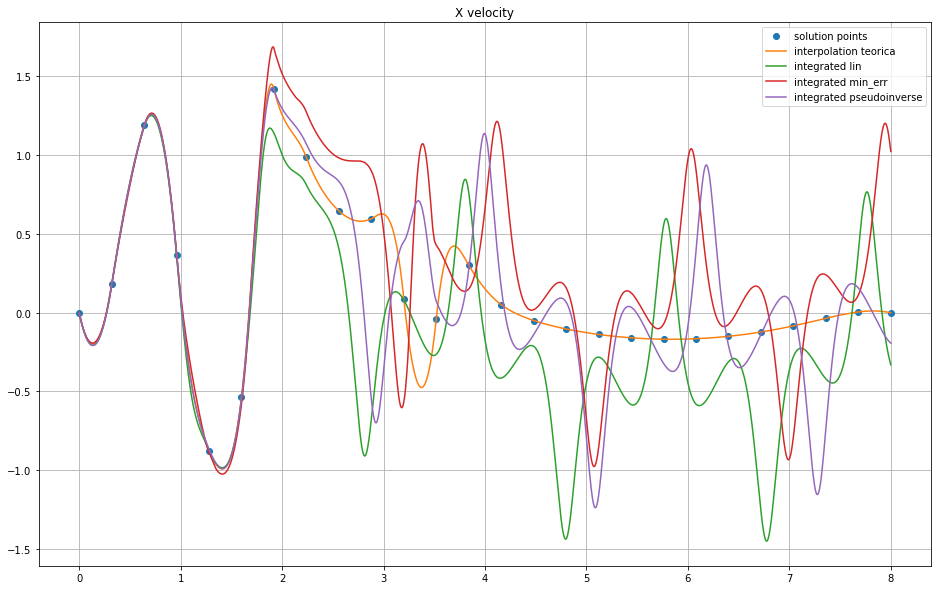

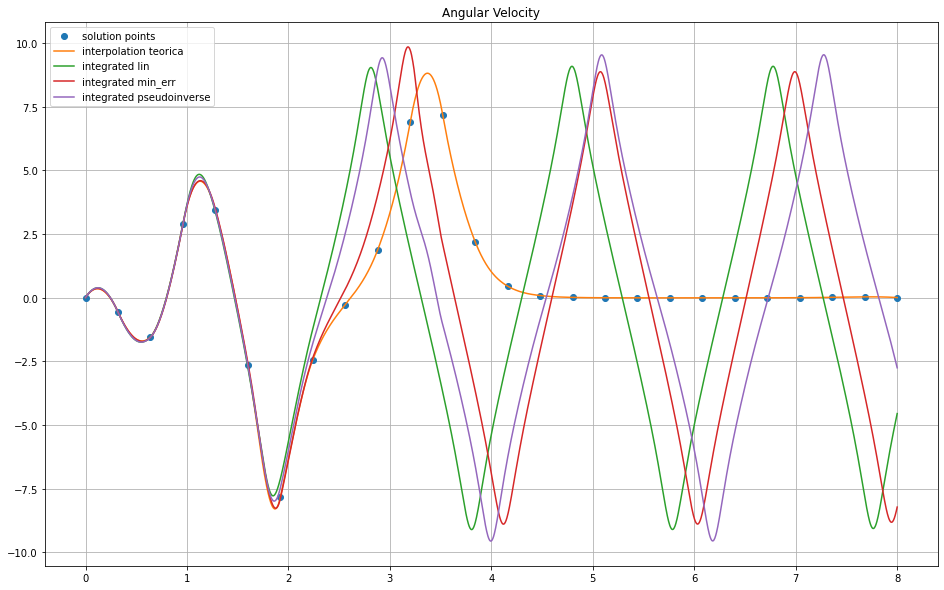

In [91]:
titles = ['X position', 'Angle', 'X velocity', 'Angular Velocity']
for ii in range(4):
    plt.figure(figsize=[16,10])
    plt.plot(np.linspace(0,t_end,N_prob+1),results[key][N_prob]['x'][:,ii], 'o',label = 'solution points')
    plt.plot(np.linspace(0,t_end,2000),xx_int[:,ii], label = 'interpolation teorica')
    plt.plot(np.linspace(0,t_end,2000),xx_integr_lin[:,ii], label = 'integrated lin')
    plt.plot(np.linspace(0,t_end,2000),xx_integr_min_err[:,ii], label = 'integrated min_err')
    plt.plot(np.linspace(0,t_end,2000),xx_integr_pinv[:,ii], label = 'integrated pseudoinverse')
    plt.grid()
    plt.legend()
    plt.title(titles[ii])

In [92]:
schemes = ['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
init = 'prev_sol'
N_arr = [10,15,20,25,30,40,50,75,100,150]
t_end_values = [2, 4, 8]


for scheme in schemes:
    for t_end in t_end_values:
        key = f'{scheme}_{init}_{t_end}'
        new_key = key +'_min_err'
        print('Problem:', key)
        u_scheme = 'min_err'
        err_table = []
        for N in N_arr:
            print(f'\tN = {N}')
            errors = list(calculate_integrated_errors(
                X = results[key][N]['x'],
                U = results[key][N]['u'],
                F = F_nump,
                t_end = t_end,
                params = params,
                scheme = scheme,
                u_scheme = u_scheme,
                scheme_params = {'u_c':results[key][N]['u_c']},
                n_interp = 3000,
                int_fun = integrate_rk4))
            err_table.append(errors)
        integ_errors_dict[new_key] = np.array(err_table)

Problem: hs_prev_sol_2
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_prev_sol_4
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_prev_sol_8
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_mod_prev_sol_2
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_mod_prev_sol_4
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_mod_prev_sol_8
	N = 10
	N = 15
	N = 20
	N = 25
	N = 30
	N = 40
	N = 50
	N = 75
	N = 100
	N = 150
Problem: hs_parab_prev_sol_2
	N = 10


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 15


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 20


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 25


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 30


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 40


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 50


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 75


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 100


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 150


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


Problem: hs_parab_prev_sol_4
	N = 10


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 15


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 20


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 25


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 30


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 40


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 50


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 75


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 100


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 150


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


Problem: hs_parab_prev_sol_8
	N = 10


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 15


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 20


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 25


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 30


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 40


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 50


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 75


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 100


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 150


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


Problem: hs_mod_parab_prev_sol_2
	N = 10


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 15


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 20


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 25


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 30


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 40


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 50


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 75


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 100


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 150


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


Problem: hs_mod_parab_prev_sol_4
	N = 10


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 15


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 20


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 25


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 30


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


	N = 40


/Users/smorenom/Documents/Python/Repo Github/optibot/optibot/analysis.py:109: UserWarning: You are currently using a u-parabolic interpolation for x with a lineal interpolation of u
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
integ_errors_dict[key][:,ii]

In [ ]:
nn

In [ ]:
t_end = 4
schemes = ['hs', 'hs_mod']#, 'hs_parab', 'hs_mod_parab']
init = 'prev_sol'
titles = ['accumulated dynamic error in q',
          'accumulated dynamic error in v',
          'accumulated second order dynamic error',
          'accumulated segmented deviation error']

for ii in range(4):
    plt.figure(figsize=[15,10])
    for scheme in schemes:
        key = f'{scheme}_{init}_{t_end}'
        new_key = key +'_min_err'
        nn = results[key]['N_arr']
        plt.plot(nn, integ_errors_dict[key][:,ii], label = scheme)
        plt.plot(nn, integ_errors_dict[new_key][:,ii], label = scheme+ '_min_err')
        new_key = key +'_pinv'
        plt.plot(nn, integ_errors_dict[new_key][:,ii], label = scheme+ '_pinv')
    plt.title(f'{titles[ii]}, t_end = {t_end} s')
    plt.grid()
    plt.legend()
    plt.yscale('log')

## Random init and stability

In [ ]:
schemes = ['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
solve_repetitions = 50
N_arr = [10,15,20,25,30,40,50,75,100,150]
t_end_values = [2, 4, 8]

for scheme in schemes:
    init = 'random'
    for t_end in t_end_values:
        key = f'{scheme}_{init}_{t_end}'
        
        print('Problem:', key)
        results[key] = {'N_arr':N_arr}
        for N in N_arr:
            print(f'\tN = {N}')
            xx, uu, uu_c, cpudt, n_err, cost = casadi_cartpole(N, scheme, init, solve_repetitions, t_end)
            results[key][N] = {
                'x': xx,
                'u': uu,
                'u_c': uu_c,
                'cpudt': cpudt,
                't_end': t_end,
                'n_err': n_err,
                'cost': cost
            }

In [ ]:

t_end_values = [2, 4, 8]
schemes = ['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
init = 'random'

for ii in range(3):
    t_end = t_end_values[ii]
    plt.figure(figsize=[15,10])
    for scheme in schemes:
        key = f'{scheme}_{init}_{t_end}'
        nn = results[key]['N_arr']
        n_err = [results[key][jj]['n_err'] for jj in nn]
        plt.plot(nn, n_err, label = scheme)
    plt.title(f'non-convergence rate, t_end = {t_end} s')
    plt.grid()
    plt.legend()
    plt.yscale('log')

In [ ]:

t_end_values = [2, 4, 8]
schemes = ['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
init = 'random'

for ii in range(3):
    t_end = t_end_values[ii]
    plt.figure(figsize=[15,10])
    for scheme in schemes:
        key = f'{scheme}_{init}_{t_end}'
        nn = results[key]['N_arr']
        n_err = [results[key][jj]['cost'] for jj in nn]
        plt.plot(nn, n_err, label = scheme)
    plt.title(f'Mean trayectory cost, t_end = {t_end} s')
    plt.grid()
    plt.legend()
    #plt.yscale('log')

In [ ]:

t_end_values = [2, 4, 8]
schemes = ['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
init = 'random'

for ii in range(3):
    t_end = t_end_values[ii]
    plt.figure(figsize=[15,10])
    for scheme in schemes:
        key = f'{scheme}_{init}_{t_end}'
        nn = results[key]['N_arr']
        n_err = [results[key][jj]['cpudt'] for jj in nn]
        plt.plot(nn, n_err, label = scheme)
    plt.title(f'Mean convergence time, t_end = {t_end} s')
    plt.grid()
    plt.legend()
    #plt.yscale('log')

## Save trayectories

In [ ]:
schemes = ['hs', 'hs_mod', 'hs_mod', ]#['hs', 'hs_mod', 'hs_parab', 'hs_mod_parab']
initials = ['prev_sol', 'prev_sol', 'prev_sol']#['lin', 'funcs', 'zero', 'prev_sol']
N_arr = [25, 25, 25]#[10,15,20,25,30,40]#50,75,100,150]
t_end_values = [8,8,8]#[2, 4, 8]
u_schemes = ['lin', 'lin', 'pinv_dyn']
n_interp = 3000


for jj in range(len(schemes)):
    scheme = schemes[jj]
    init = initials[jj]
    t_end = t_end_values[jj]
    t_array = np.linspace(0, t_end, n_interp)
    N_prob = N_arr[jj]
    u_scheme = u_schemes[jj]
    
    key = f'{scheme}_{init}_{t_end}'
    xx, uu = interpolated_array(
        results[key][N_prob]['x'],
        results[key][N_prob]['u'],
        F_nump,
        t_end/N_prob,
        t_array,
        params,
        scheme,
        u_scheme,
        {'u_c' : results[key][N_prob]['u_c'],
                        'pinv_f': num_pinv_dyn}
    )
    res = np.append(np.expand_dims(t_array, 1), np.expand_dims(uu, 1), 1)
    res = np.append(res, xx, 1)
    np.savetxt(f'cartpole_siro_underactuated_{key}_{u_scheme}.txt', res)
